# EDA

## Importações e Configurações Iniciais

In [2]:
!pip install polars seaborn

In [3]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

## Carregamento dos Dados

In [4]:
cse = pl.read_csv("cse-cic-ids2018-final.csv")

cse.head()

Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,…,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,timestamp
i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,i64,i64,i64,f64,f64,i64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,…,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,f64,f64,i64,i64,str,str
0,0,112641719,3,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.026633,5.6321e7,139.300036,56320958,56320761,112641719,5.6321e7,139.300036,56320958,56320761,0,0.0,0.0,0,0,0,0,0,0,0,0,…,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0.0,0.0,0,0,5.6321e7,139.300036,56320958,56320761,"""Benign""","""2018-02-14 08:31:01"""
0,0,112641466,3,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.026633,5.6320733e7,114.551299,56320814,56320652,112641466,5.6320733e7,114.551299,56320814,56320652,0,0.0,0.0,0,0,0,0,0,0,0,0,…,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0.0,0.0,0,0,5.6320733e7,114.551299,56320814,56320652,"""Benign""","""2018-02-14 08:33:50"""
0,0,112638623,3,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.026634,5.6319e7,301.934596,56319525,56319098,112638623,5.6319e7,301.934596,56319525,56319098,0,0.0,0.0,0,0,0,0,0,0,0,0,…,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0.0,0.0,0,0,5.6319e7,301.934596,56319525,56319098,"""Benign""","""2018-02-14 08:36:39"""
22,6,6453966,15,10,1239,2273,744,0,82.6,196.741237,976,0,227.3,371.677892,544.161528,3.873587,268915.25,247443.778966,673900,22,6453966,460997.571429,123109.423588,673900,229740,5637902,626433.555556,455082.214224,1167293,554,0,0,0,0,488,328,…,77192.153846,0,0,0,1,0,0,0,0,0,140.48,82.6,227.3,0,0,0,0,0,0,15,1239,10,2273,65535,233,6,32,0.0,0.0,0,0,0.0,0.0,0,0,"""Benign""","""2018-02-14 08:40:13"""
22,6,8804066,14,11,1143,2209,744,0,81.642857,203.745545,976,0,200.818182,362.249864,380.733175,2.839597,366836.083333,511356.609733,1928102,21,8804066,677235.846154,532416.970959,1928102,246924,7715481,771548.1,755543.082717,2174893,90,0,0,0,0,456,360,…,78267.353846,0,0,0,1,0,0,0,0,0,134.08,81.642857,200.818182,0,0,0,0,0,0,14,1143,11,2209,5808,233,6,32,0.0,0.0,0,0,0.0,0.0,0,0,"""Benign""","""2018-02-14 08:40:23"""


## Pré-processamento

### Remover Valores Nulos

In [5]:
cse = cse.drop_nulls()

### Remover Colunas Constantes

In [6]:
cse = cse.drop([col for col in cse.columns if cse.select(col).n_unique() == 1])

### Remover Valores Infinitos

In [7]:
numeric_cols = [col for col, dtype in cse.schema.items() if dtype in [pl.Int64, pl.Float64, pl.Int32]]

for col in numeric_cols:
    cse = cse.filter(~pl.col(col).is_infinite())

### Verificando as Colunas Restantes

In [8]:
cse = cse.with_columns(
    pl.when(pl.col("Label") == "Benign").then(0).otherwise(1).alias("Is_Attack")
)

In [9]:
print(cse.columns)
print(f"Shape do dataset: {cse.shape}")

['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Fwd Win Byts', 'Init Bwd

## Análise Exploratória de Dados (EDA)

### Distribuição dos ataques

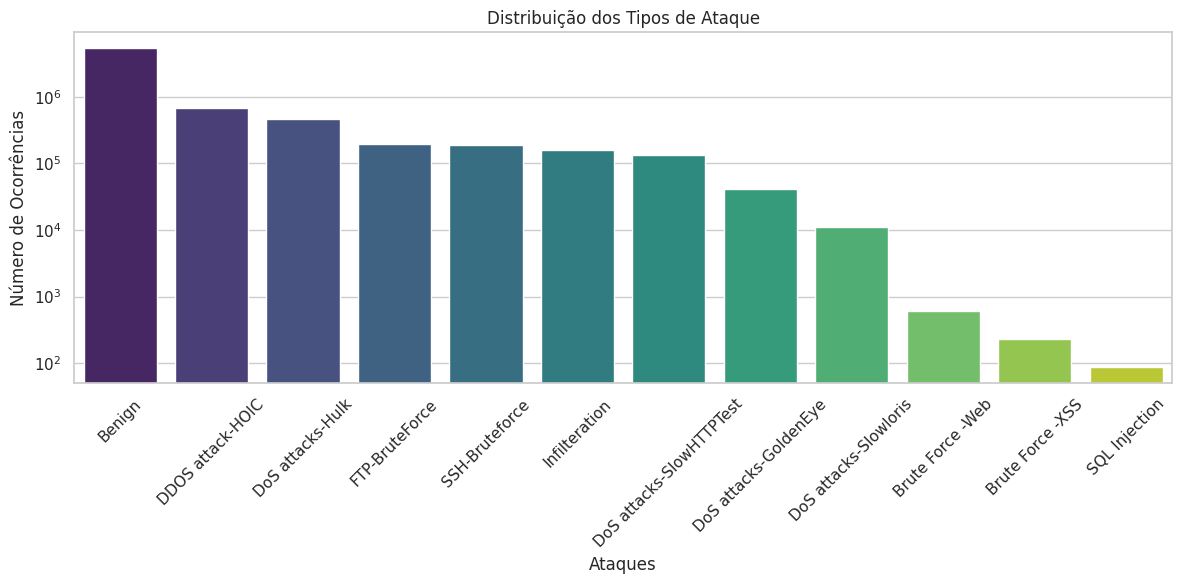

In [10]:
cse_pandas = cse.to_pandas()

label_counts = cse_pandas['Label'].value_counts().reset_index()
label_counts.columns = ['Label', 'Count']

plt.figure(figsize=(12, 6))
sns.barplot(data=label_counts, x='Label', y='Count', hue='Label', palette="viridis", dodge=False, legend=False)
plt.yscale('log')
plt.title('Distribuição dos Tipos de Ataque')
plt.xlabel('Ataques')
plt.ylabel('Número de Ocorrências')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Exploração de Features

### Identificação de Colunas Categóricas

#### Análise dos Tipos de Dados

In [11]:
print(cse_pandas.dtypes)

Dst Port          int64
Protocol          int64
Flow Duration     int64
Tot Fwd Pkts      int64
Tot Bwd Pkts      int64
                  ...  
Idle Max          int64
Idle Min          int64
Label            object
timestamp        object
Is_Attack         int32
Length: 73, dtype: object


#### Contagem de Valores Únicos

In [12]:
unique_counts = cse_pandas.nunique().sort_values()
print(unique_counts)

Fwd PSH Flags          2
FIN Flag Cnt           2
SYN Flag Cnt           2
RST Flag Cnt           2
ACK Flag Cnt           2
                  ...   
Flow IAT Mean    2584637
Fwd Pkts/s       2659447
Flow Pkts/s      2699741
Flow Byts/s      3049629
Flow IAT Std     3143860
Length: 73, dtype: int64


#### Identificar Colunas com Baixa Cardinalidade

Definimos um limiar para considerar uma coluna como tendo baixa cardinalidade. Aqui, usaremos um limiar de 15 valores únicos.

In [13]:
low_cardinality_threshold = 15

low_cardinality_cols = unique_counts[unique_counts < low_cardinality_threshold].index.tolist()
print("Colunas com baixa cardinalidade:")
print(low_cardinality_cols)

Colunas com baixa cardinalidade:
['Fwd PSH Flags', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'PSH Flag Cnt', 'ECE Flag Cnt', 'CWE Flag Count', 'Fwd URG Flags', 'Is_Attack', 'Protocol', 'Fwd Seg Size Min', 'Label']


#### Análise de Colunas Numéricas com Baixa Cardinalidade

In [14]:
numeric_cols = cse_pandas.select_dtypes(include=['int64', 'float64']).columns.tolist()

low_cardinality_numeric_cols = [col for col in numeric_cols if col in low_cardinality_cols]
print("Colunas numéricas com baixa cardinalidade:")
print(low_cardinality_numeric_cols)


Colunas numéricas com baixa cardinalidade:
['Protocol', 'Fwd PSH Flags', 'Fwd URG Flags', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'Fwd Seg Size Min']


#### Análise de Colunas Não Numéricas

In [15]:
low_cardinality_non_numeric_cols = [col for col in low_cardinality_cols if col not in numeric_cols]
print("Colunas não numéricas com baixa cardinalidade:")
print(low_cardinality_non_numeric_cols)

Colunas não numéricas com baixa cardinalidade:
['Is_Attack', 'Label']


#### Aplicar Conhecimento de Domínio

Adicionamos colunas que, apesar de não terem baixa cardinalidade, são conhecidas como categóricas no contexto do dataset.

In [16]:
domain_categorical_cols = ['Dst Port', 'Protocol']

categorical_columns = list(set(low_cardinality_cols + domain_categorical_cols))
print("Lista final de colunas categóricas:")
print(categorical_columns)
print(f"Quantidade total de colunas categóricas: {len(categorical_columns)}")

Lista final de colunas categóricas:
['Fwd PSH Flags', 'URG Flag Cnt', 'ECE Flag Cnt', 'CWE Flag Count', 'Is_Attack', 'Fwd URG Flags', 'SYN Flag Cnt', 'ACK Flag Cnt', 'Protocol', 'Label', 'PSH Flag Cnt', 'Dst Port', 'Fwd Seg Size Min', 'RST Flag Cnt', 'FIN Flag Cnt']
Quantidade total de colunas categóricas: 15


#### Análise da Distribuição dos Dados

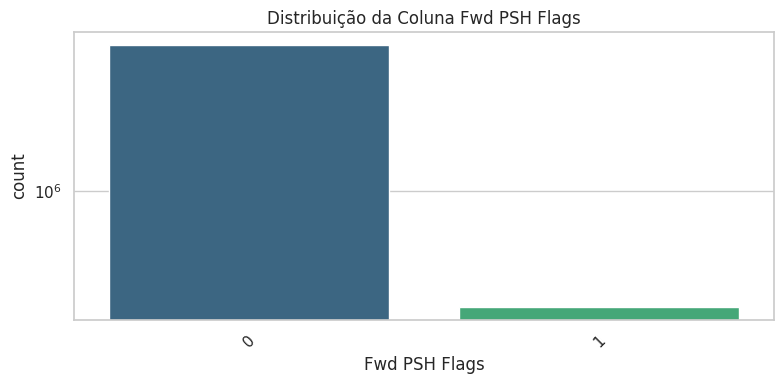

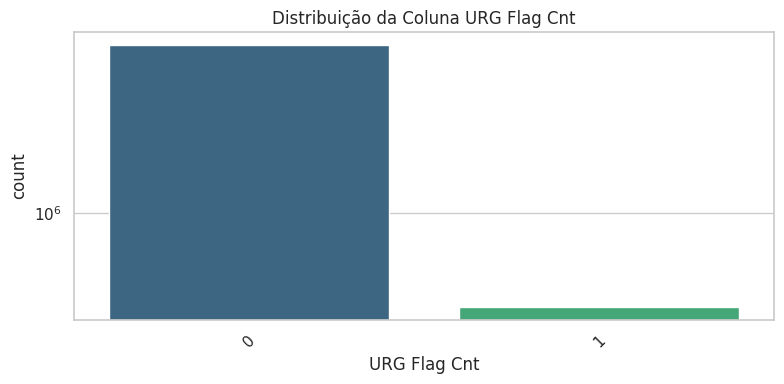

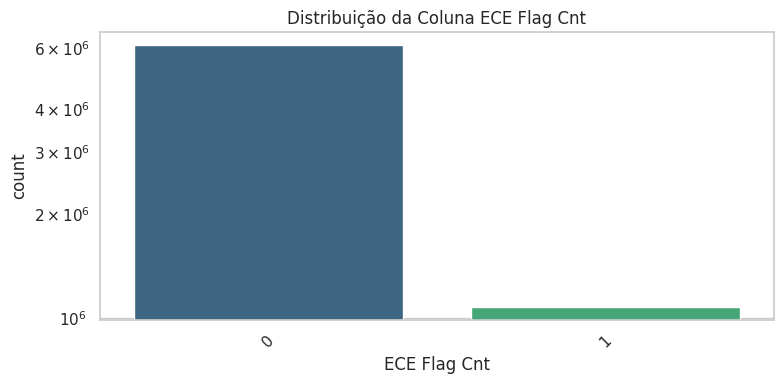

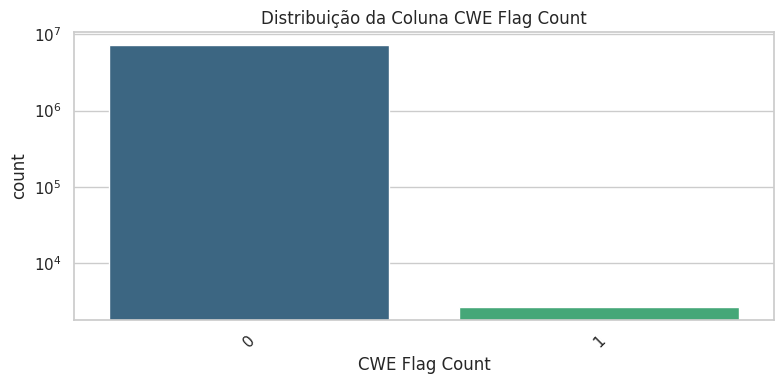

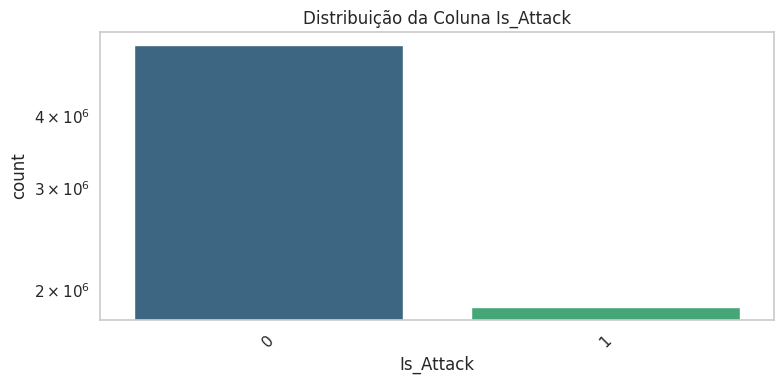

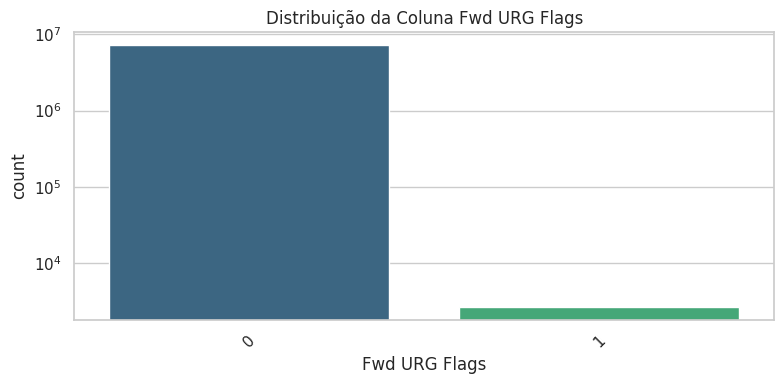

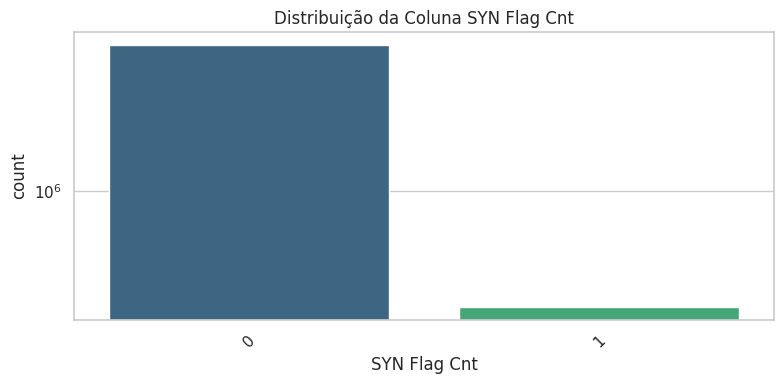

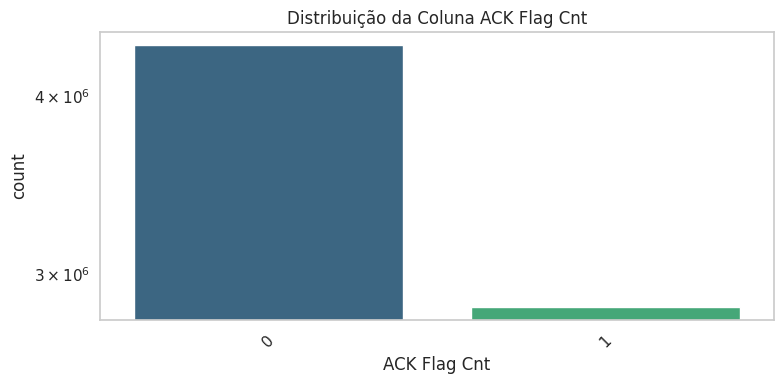

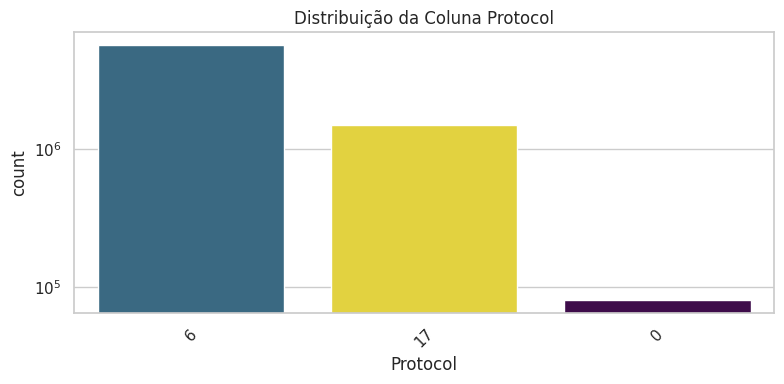

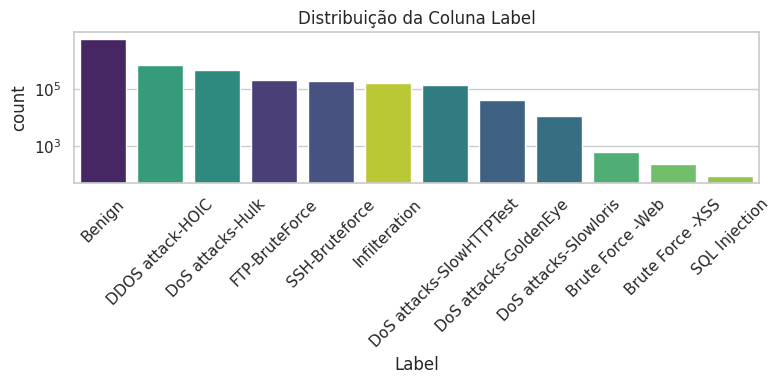

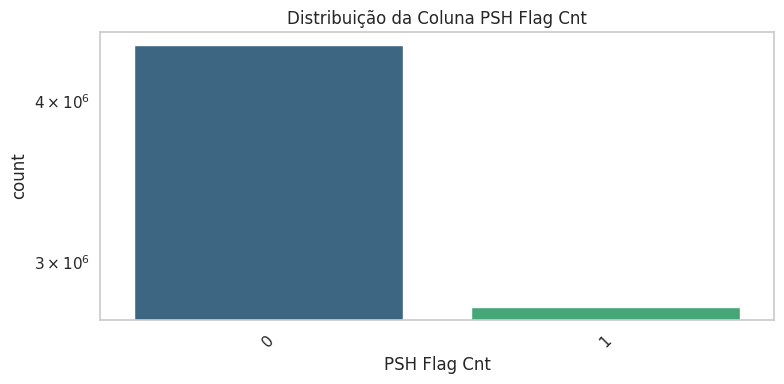

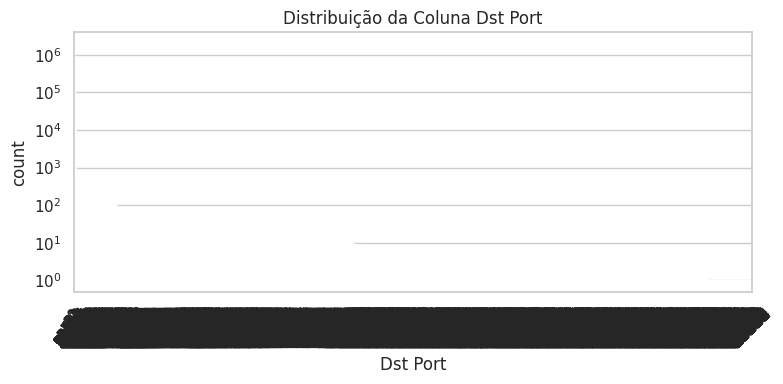

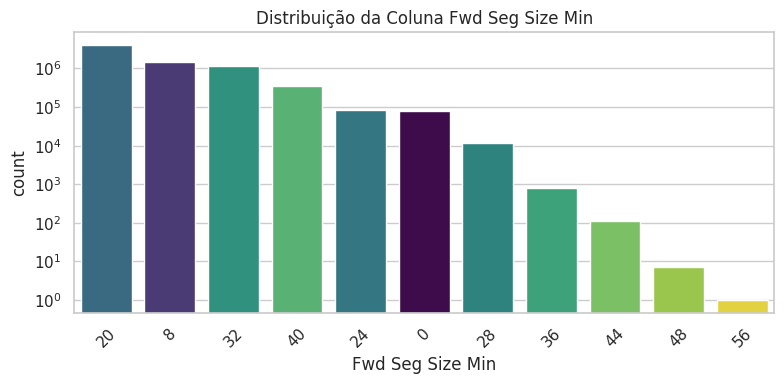

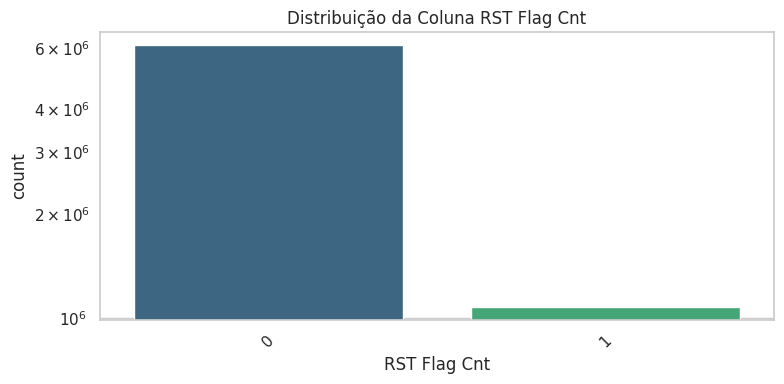

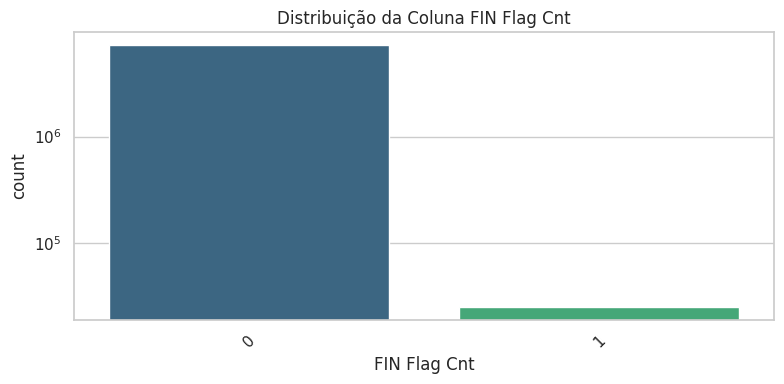

In [17]:
for col in categorical_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=cse_pandas, x=col, order=cse_pandas[col].value_counts().index, hue=col, palette="viridis", legend=False)
    plt.yscale('log')
    plt.title(f'Distribuição da Coluna {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Revisão das Colunas com Alta Cardinalidade

In [18]:
print(f"Numero de valores unicos em 'Dst Port': {cse_pandas['Dst Port'].nunique()}")

Numero de valores unicos em 'Dst Port': 63552


Basicamente, 'Dst Port' indica a porta de destino para onde o tráfego de rede está indo. Cada porta representa um serviço específico. Por exemplo:

Porta 80: tráfego HTTP (web).
Porta 443: tráfego HTTPS (web seguro).
Porta 22: acesso remoto via SSH.

Se o número de valores únicos for muito grande, consideramos:

Agrupar categorias menos frequentes em uma única categoria 'Outros'.
Aplicar técnicas de codificação adequadas, como Target Encoding ou Frequency Encoding.
Utilizar algoritmos que lidam bem com variáveis categóricas de alta cardinalidade.

### Atualização da Lista de Colunas Categóricas

In [19]:
categorical_columns = [
    col for col in categorical_columns
    if col in cse_pandas.columns  
]
print("Lista atualizada de colunas categóricas:")
print(categorical_columns)

Lista atualizada de colunas categóricas:
['Fwd PSH Flags', 'URG Flag Cnt', 'ECE Flag Cnt', 'CWE Flag Count', 'Is_Attack', 'Fwd URG Flags', 'SYN Flag Cnt', 'ACK Flag Cnt', 'Protocol', 'Label', 'PSH Flag Cnt', 'Dst Port', 'Fwd Seg Size Min', 'RST Flag Cnt', 'FIN Flag Cnt']


### Conversão de Colunas Categóricas para Tipo 'category'

In [20]:
for col in categorical_columns:
    cse_pandas[col] = cse_pandas[col].astype('category')

### Atualizar Lista de Colunas Numéricas

In [21]:
numeric_columns = cse_pandas.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_columns = [col for col in numeric_columns if col not in categorical_columns]
print("Colunas numéricas atualizadas:")
print(numeric_columns)

Colunas numéricas atualizadas:
['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']


## Análise de Correlação

### Analisando por Pearson

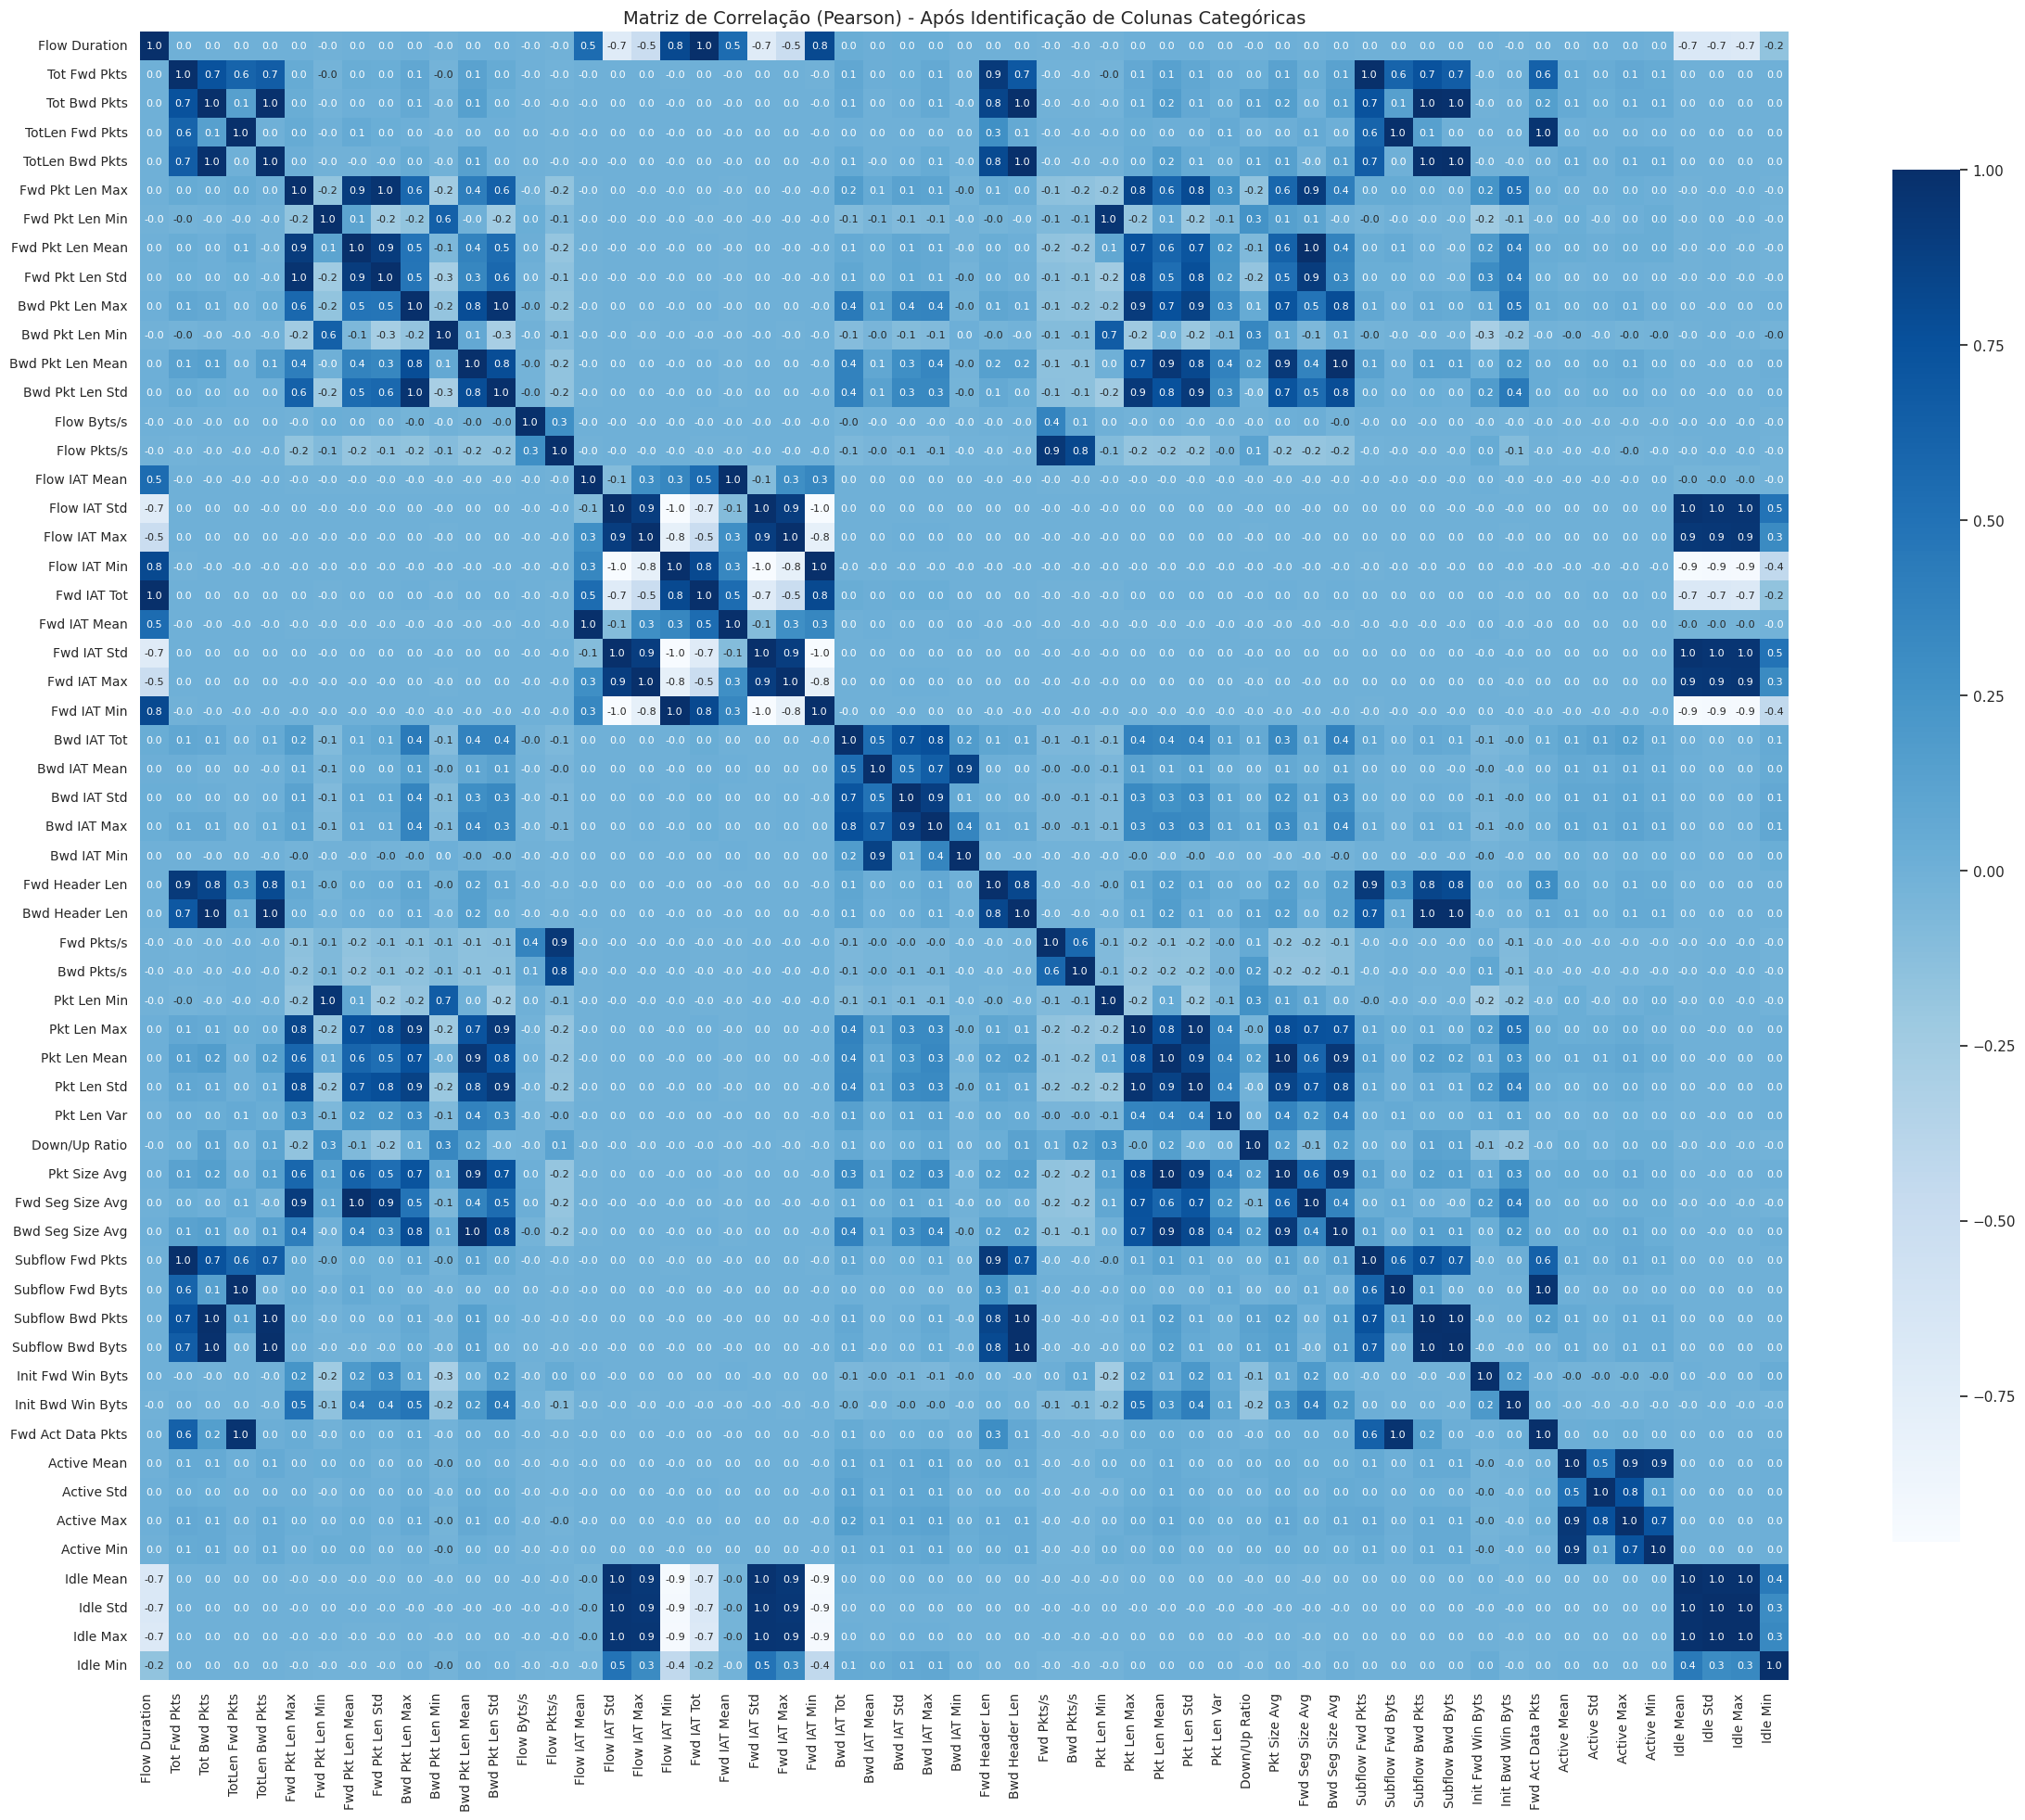

In [22]:
pearson_corr_matrix = cse_pandas[numeric_columns].corr(method="pearson")

plt.figure(figsize=(24, 20))
sns.heatmap(pearson_corr_matrix, annot=True, fmt=".1f", cmap='Blues', square=True, 
            annot_kws={"size": 8}, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlação (Pearson) - Após Identificação de Colunas Categóricas', fontsize=14)
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

### Analisando por Spearman

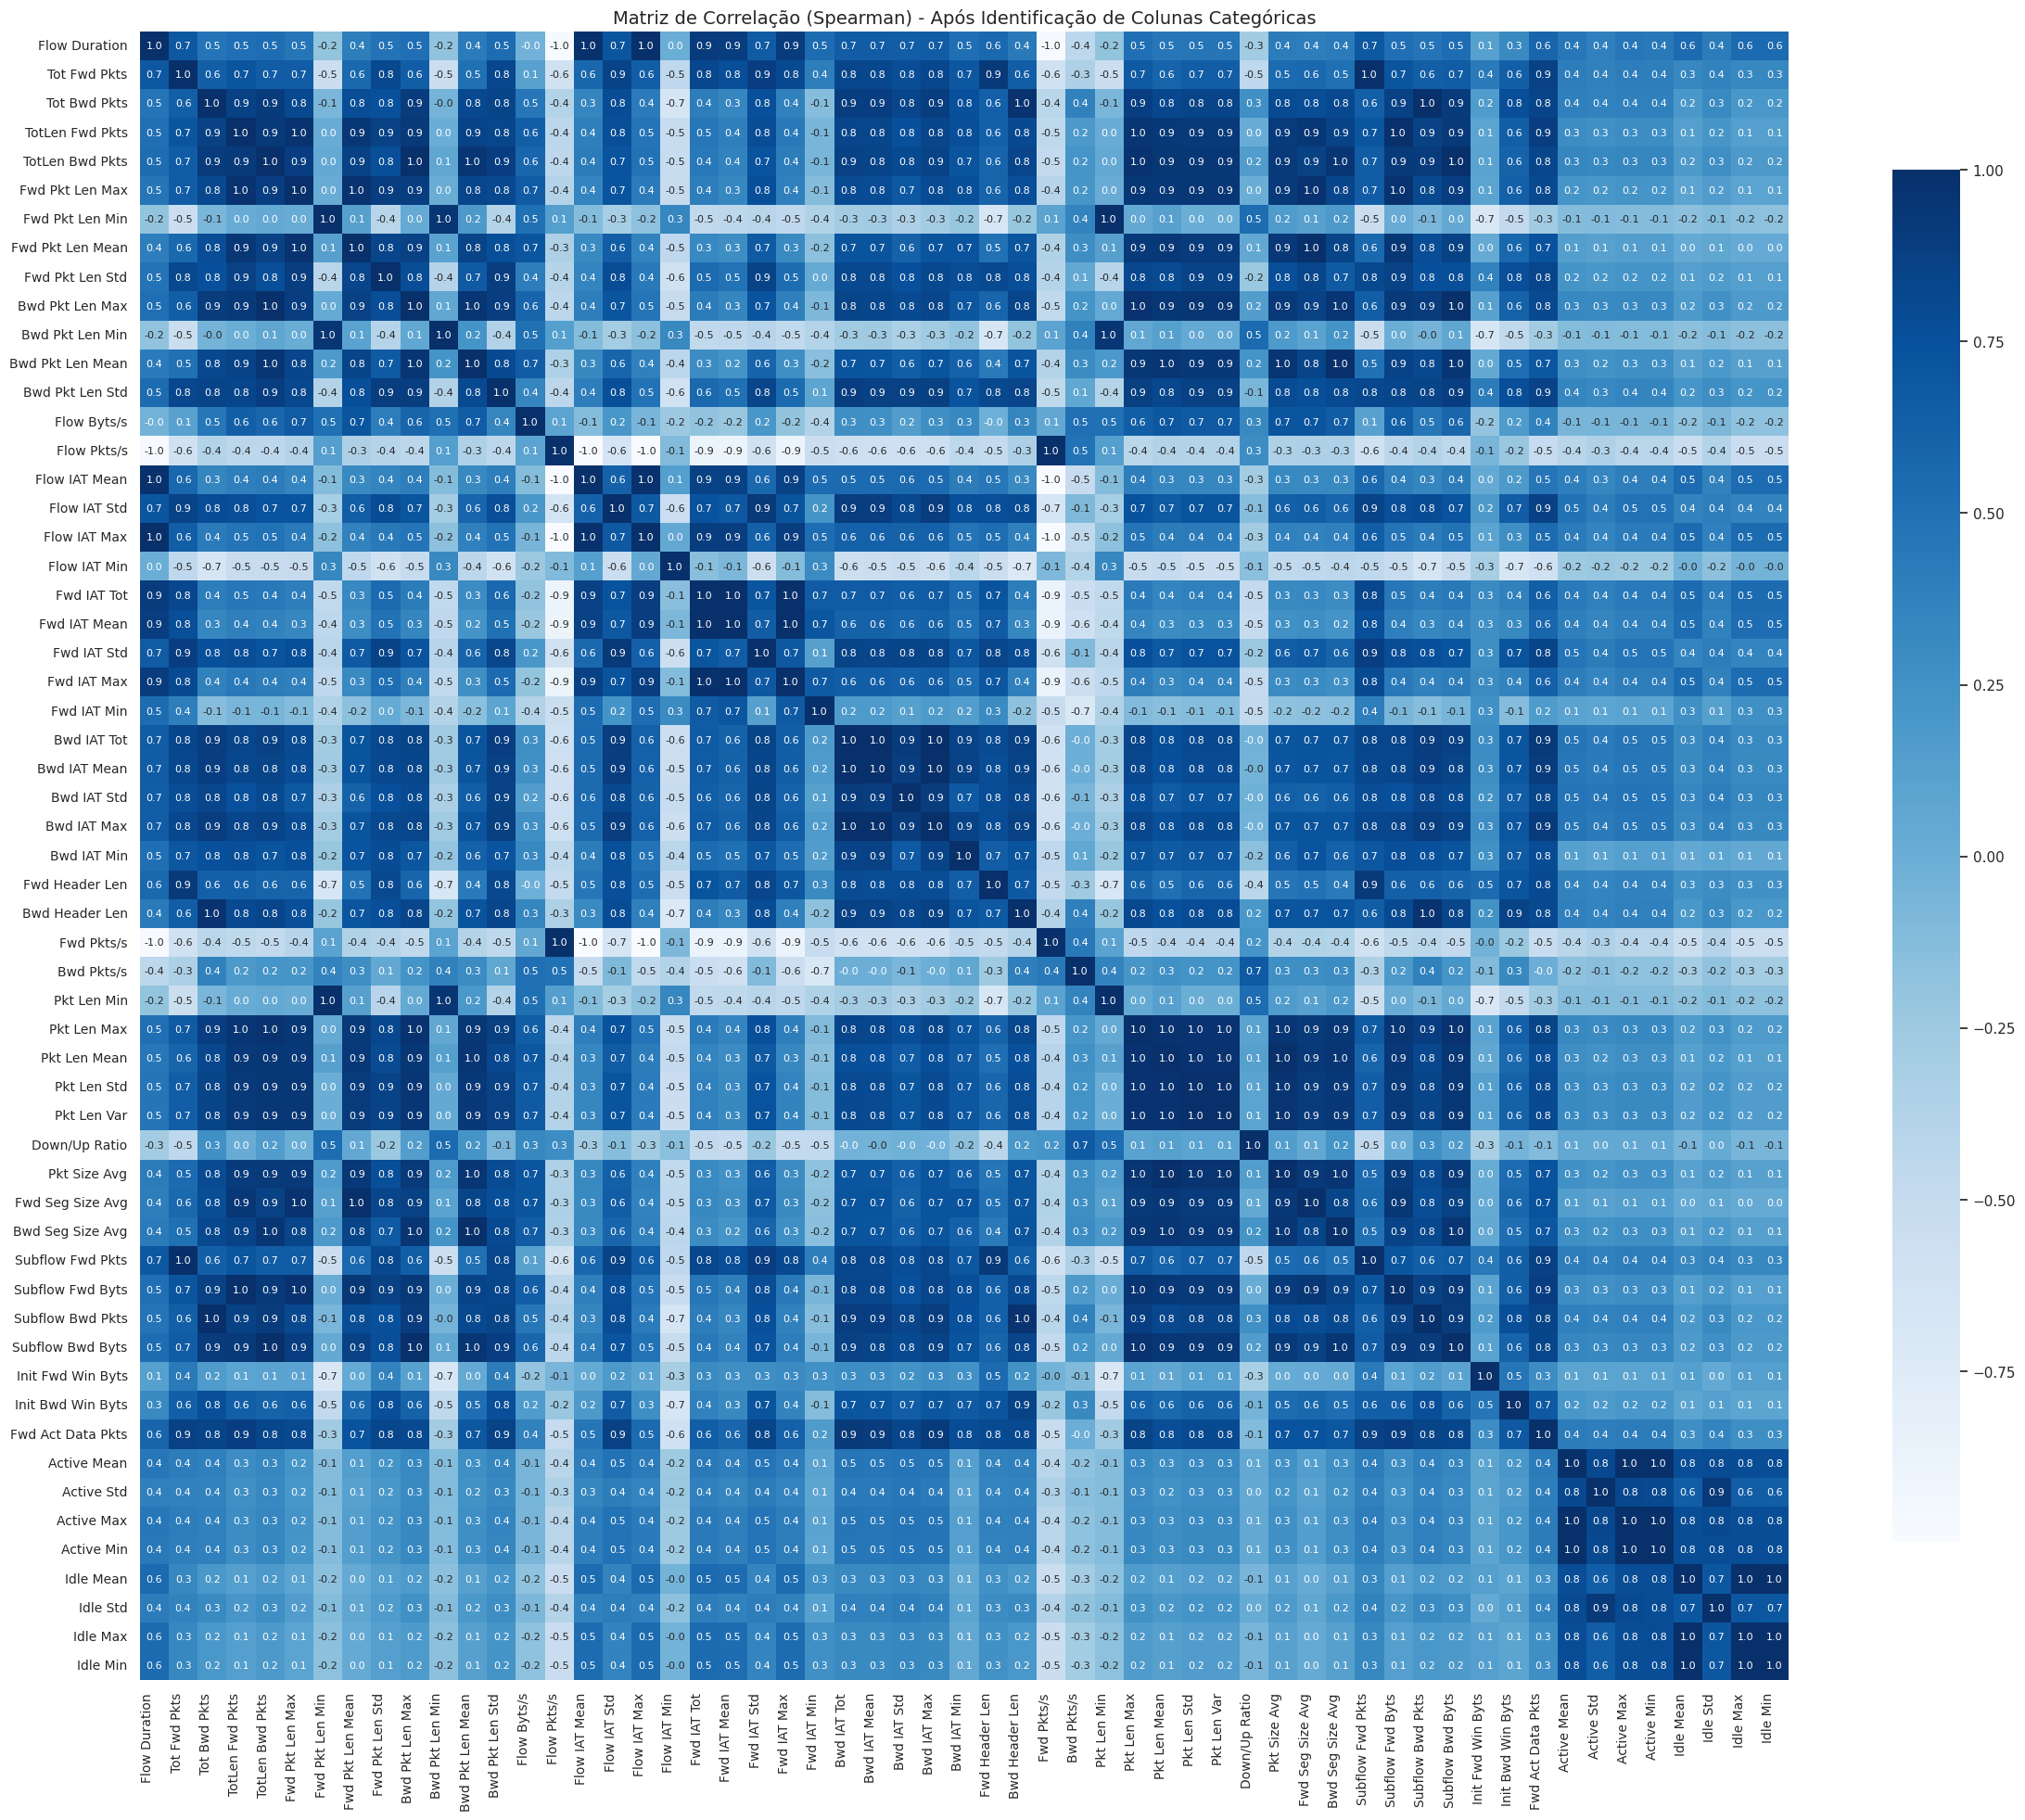

In [23]:
spearman_corr_matrix = cse_pandas[numeric_columns].corr(method="spearman")

plt.figure(figsize=(24, 20))
sns.heatmap(spearman_corr_matrix, annot=True, fmt=".1f", cmap='Blues', square=True, 
            annot_kws={"size": 8}, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlação (Spearman) - Após Identificação de Colunas Categóricas', fontsize=14)
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

### Remover Colunas Altamente Correlacionadas

In [24]:
def remove_highly_correlated(corr_matrix, data, threshold):
    import numpy as np
    to_remove = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                col1 = corr_matrix.columns[i]
                col2 = corr_matrix.columns[j]
                # decisao baseada na variancia
                var_col1 = np.var(data[col1])
                var_col2 = np.var(data[col2])
                if var_col1 < var_col2:
                    to_remove.add(col1)
                else:
                    to_remove.add(col2)
    return list(to_remove)

In [25]:
threshold = 0.95

cols_to_remove_pearson = remove_highly_correlated(pearson_corr_matrix, cse_pandas, threshold)
cols_to_remove_spearman = remove_highly_correlated(spearman_corr_matrix, cse_pandas, threshold)

print(f"Colunas a serem removidas (Pearson): {cols_to_remove_pearson}\n")
print(f"Colunas a serem removidas (Spearman): {cols_to_remove_spearman}")

Colunas a serem removidas (Pearson): ['Bwd Header Len', 'Fwd Act Data Pkts', 'Subflow Bwd Byts', 'Bwd Pkt Len Mean', 'Flow IAT Std', 'Fwd IAT Max', 'TotLen Fwd Pkts', 'Fwd Pkt Len Mean', 'Flow IAT Min', 'Tot Bwd Pkts', 'Idle Mean', 'Pkt Len Std', 'Pkt Len Mean', 'Subflow Bwd Pkts', 'Fwd IAT Tot', 'Bwd Pkt Len Std', 'Flow IAT Mean', 'Idle Std', 'Fwd Pkt Len Std', 'Pkt Len Min', 'Fwd IAT Std', 'Tot Fwd Pkts']

Colunas a serem removidas (Spearman): ['Subflow Bwd Byts', 'Bwd Pkt Len Mean', 'Bwd IAT Max', 'Flow Pkts/s', 'Fwd IAT Mean', 'TotLen Fwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Fwd Pkts/s', 'Bwd Pkt Len Max', 'Fwd Seg Size Avg', 'Active Mean', 'Tot Bwd Pkts', 'Idle Mean', 'Pkt Len Std', 'Bwd IAT Mean', 'Pkt Len Mean', 'Flow Duration', 'Subflow Bwd Pkts', 'Idle Min', 'Fwd IAT Tot', 'Flow IAT Mean', 'Active Min', 'Bwd Seg Size Avg', 'Pkt Len Max', 'Fwd Pkt Len Min', 'Pkt Len Min', 'Pkt Size Avg', 'Tot Fwd Pkts']


### Atualizando a Lista de Colunas Numéricas

In [26]:
numeric_columns_pearson = [col for col in numeric_columns if col not in cols_to_remove_pearson]
numeric_columns_spearman = [col for col in numeric_columns if col not in cols_to_remove_spearman]

### Matriz de correlação de Pearson atualizada

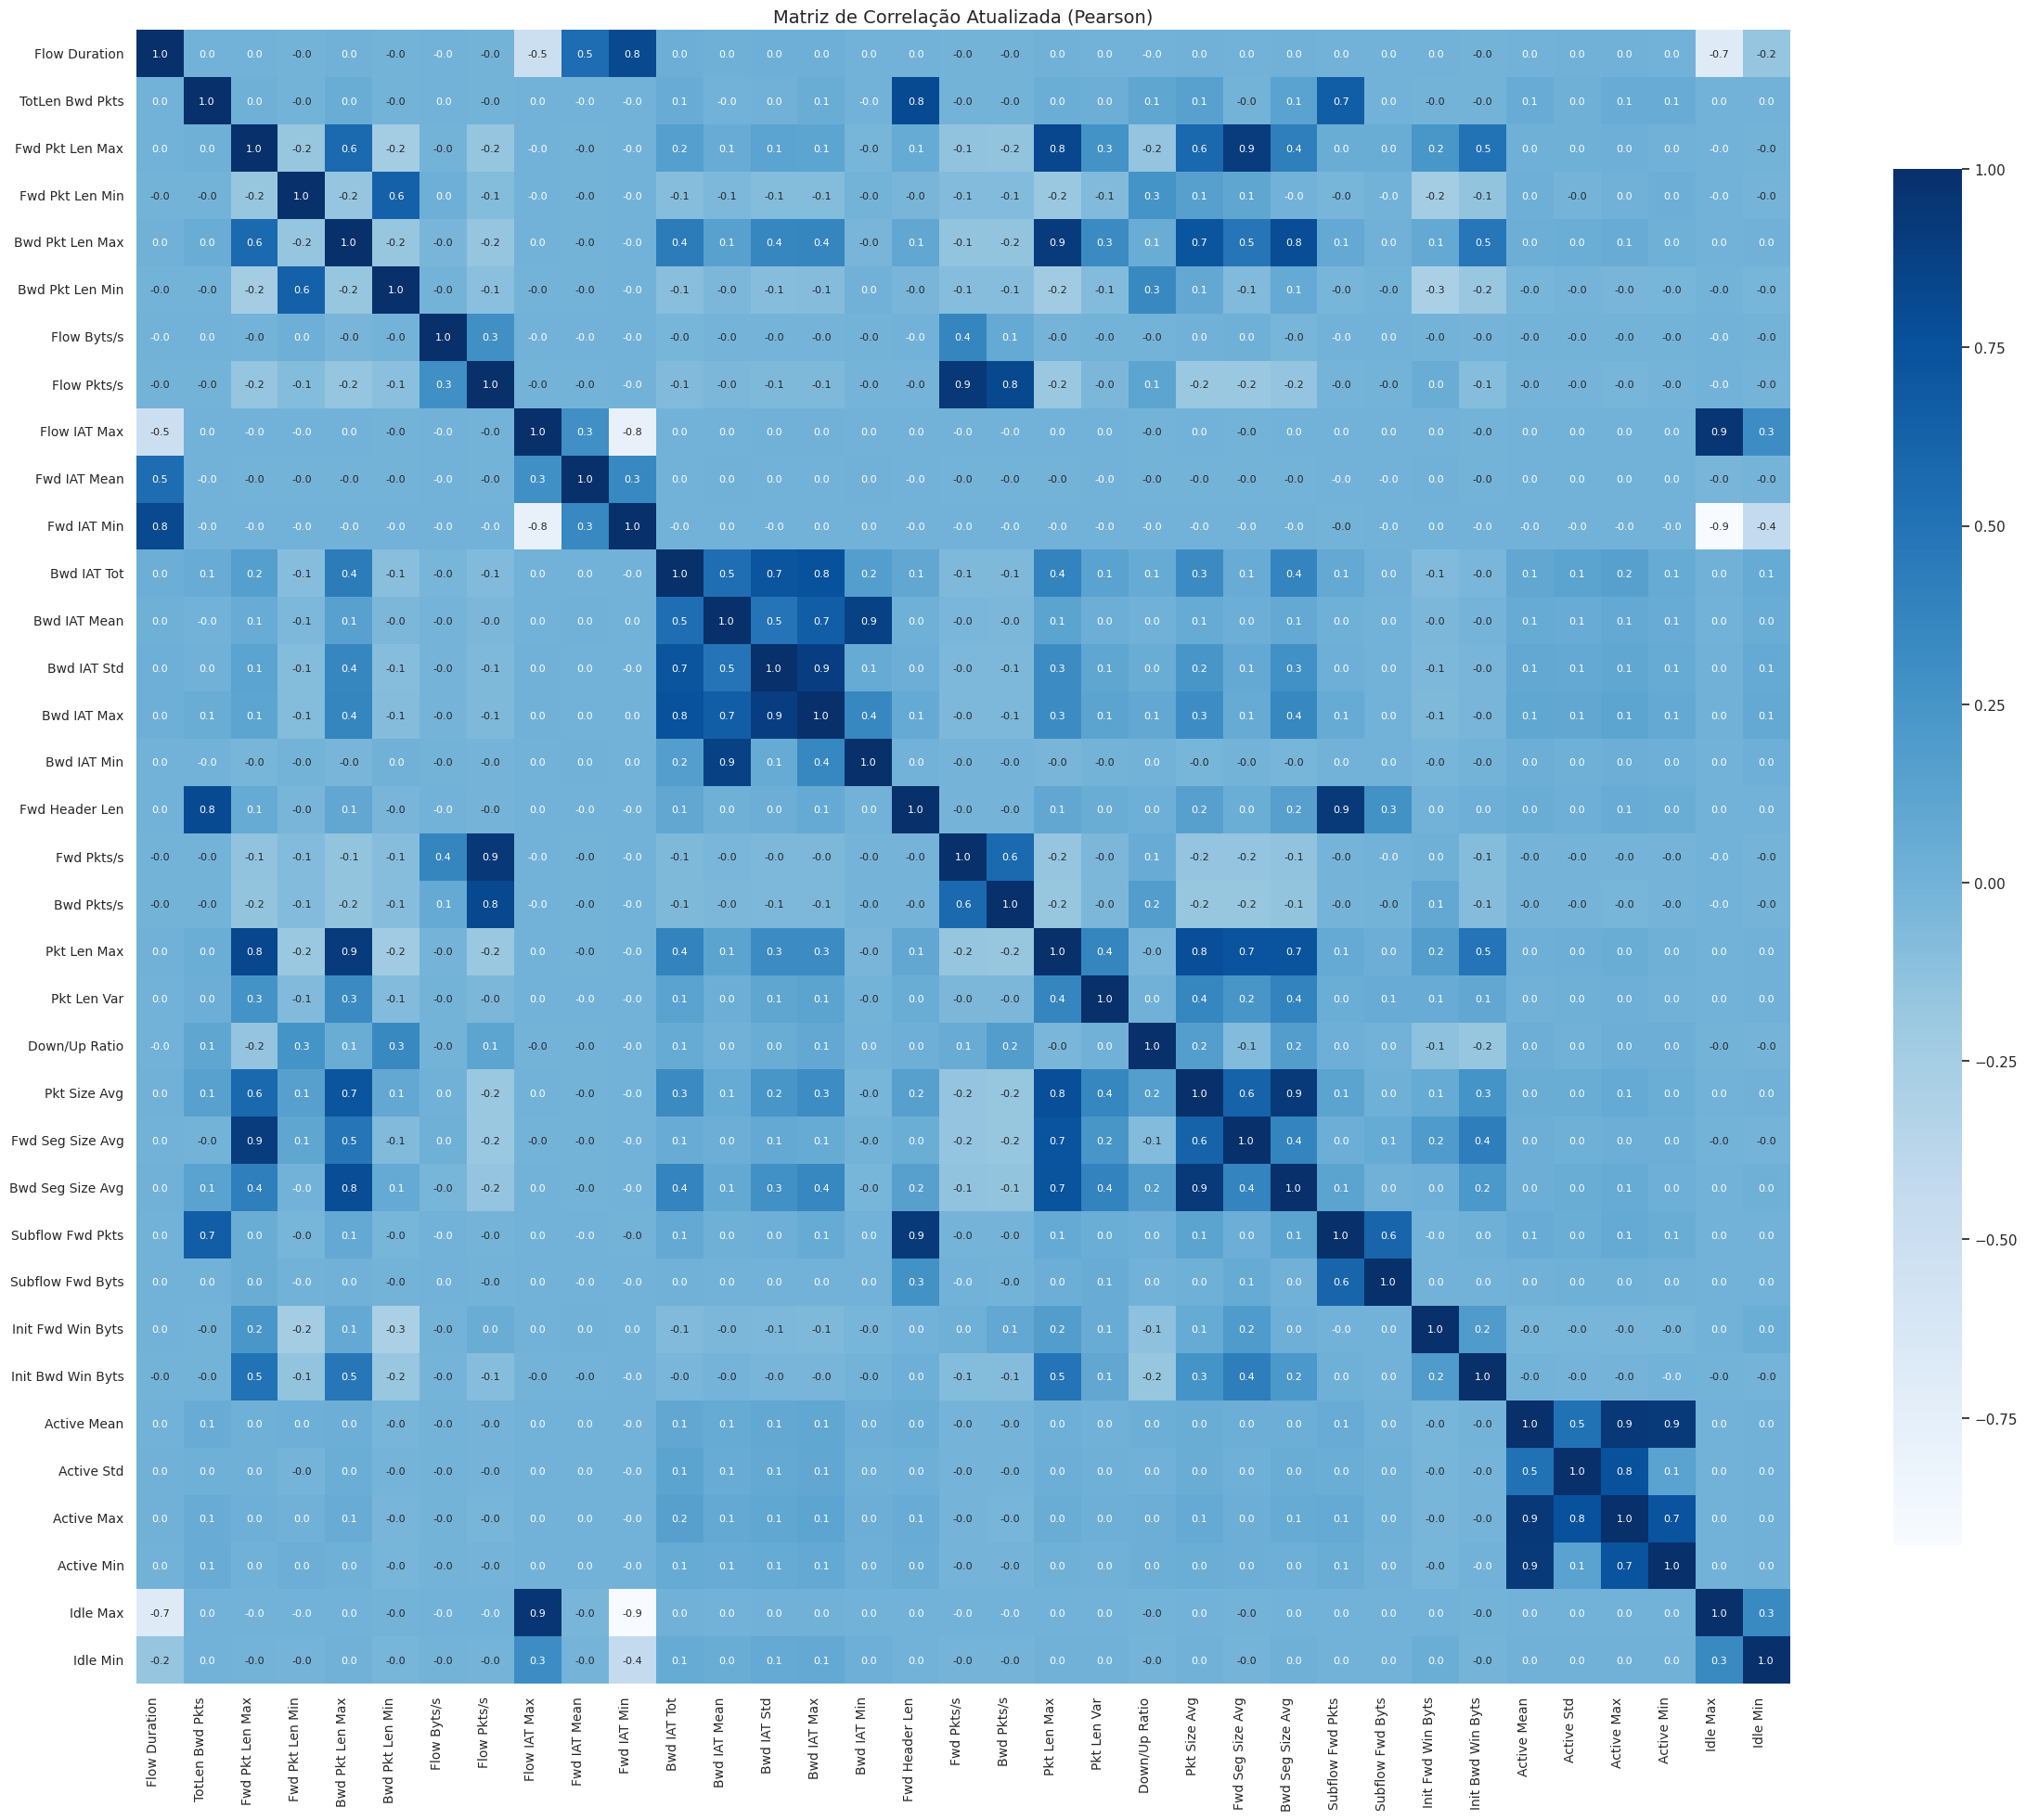

In [27]:
updated_pearson_corr_matrix = cse_pandas[numeric_columns_pearson].corr(method="pearson")

plt.figure(figsize=(24, 20))
sns.heatmap(updated_pearson_corr_matrix, annot=True, fmt=".1f", cmap='Blues', square=True, 
            annot_kws={"size": 8}, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlação Atualizada (Pearson)', fontsize=14)
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

### Matriz de correlação de Spearman atualizada

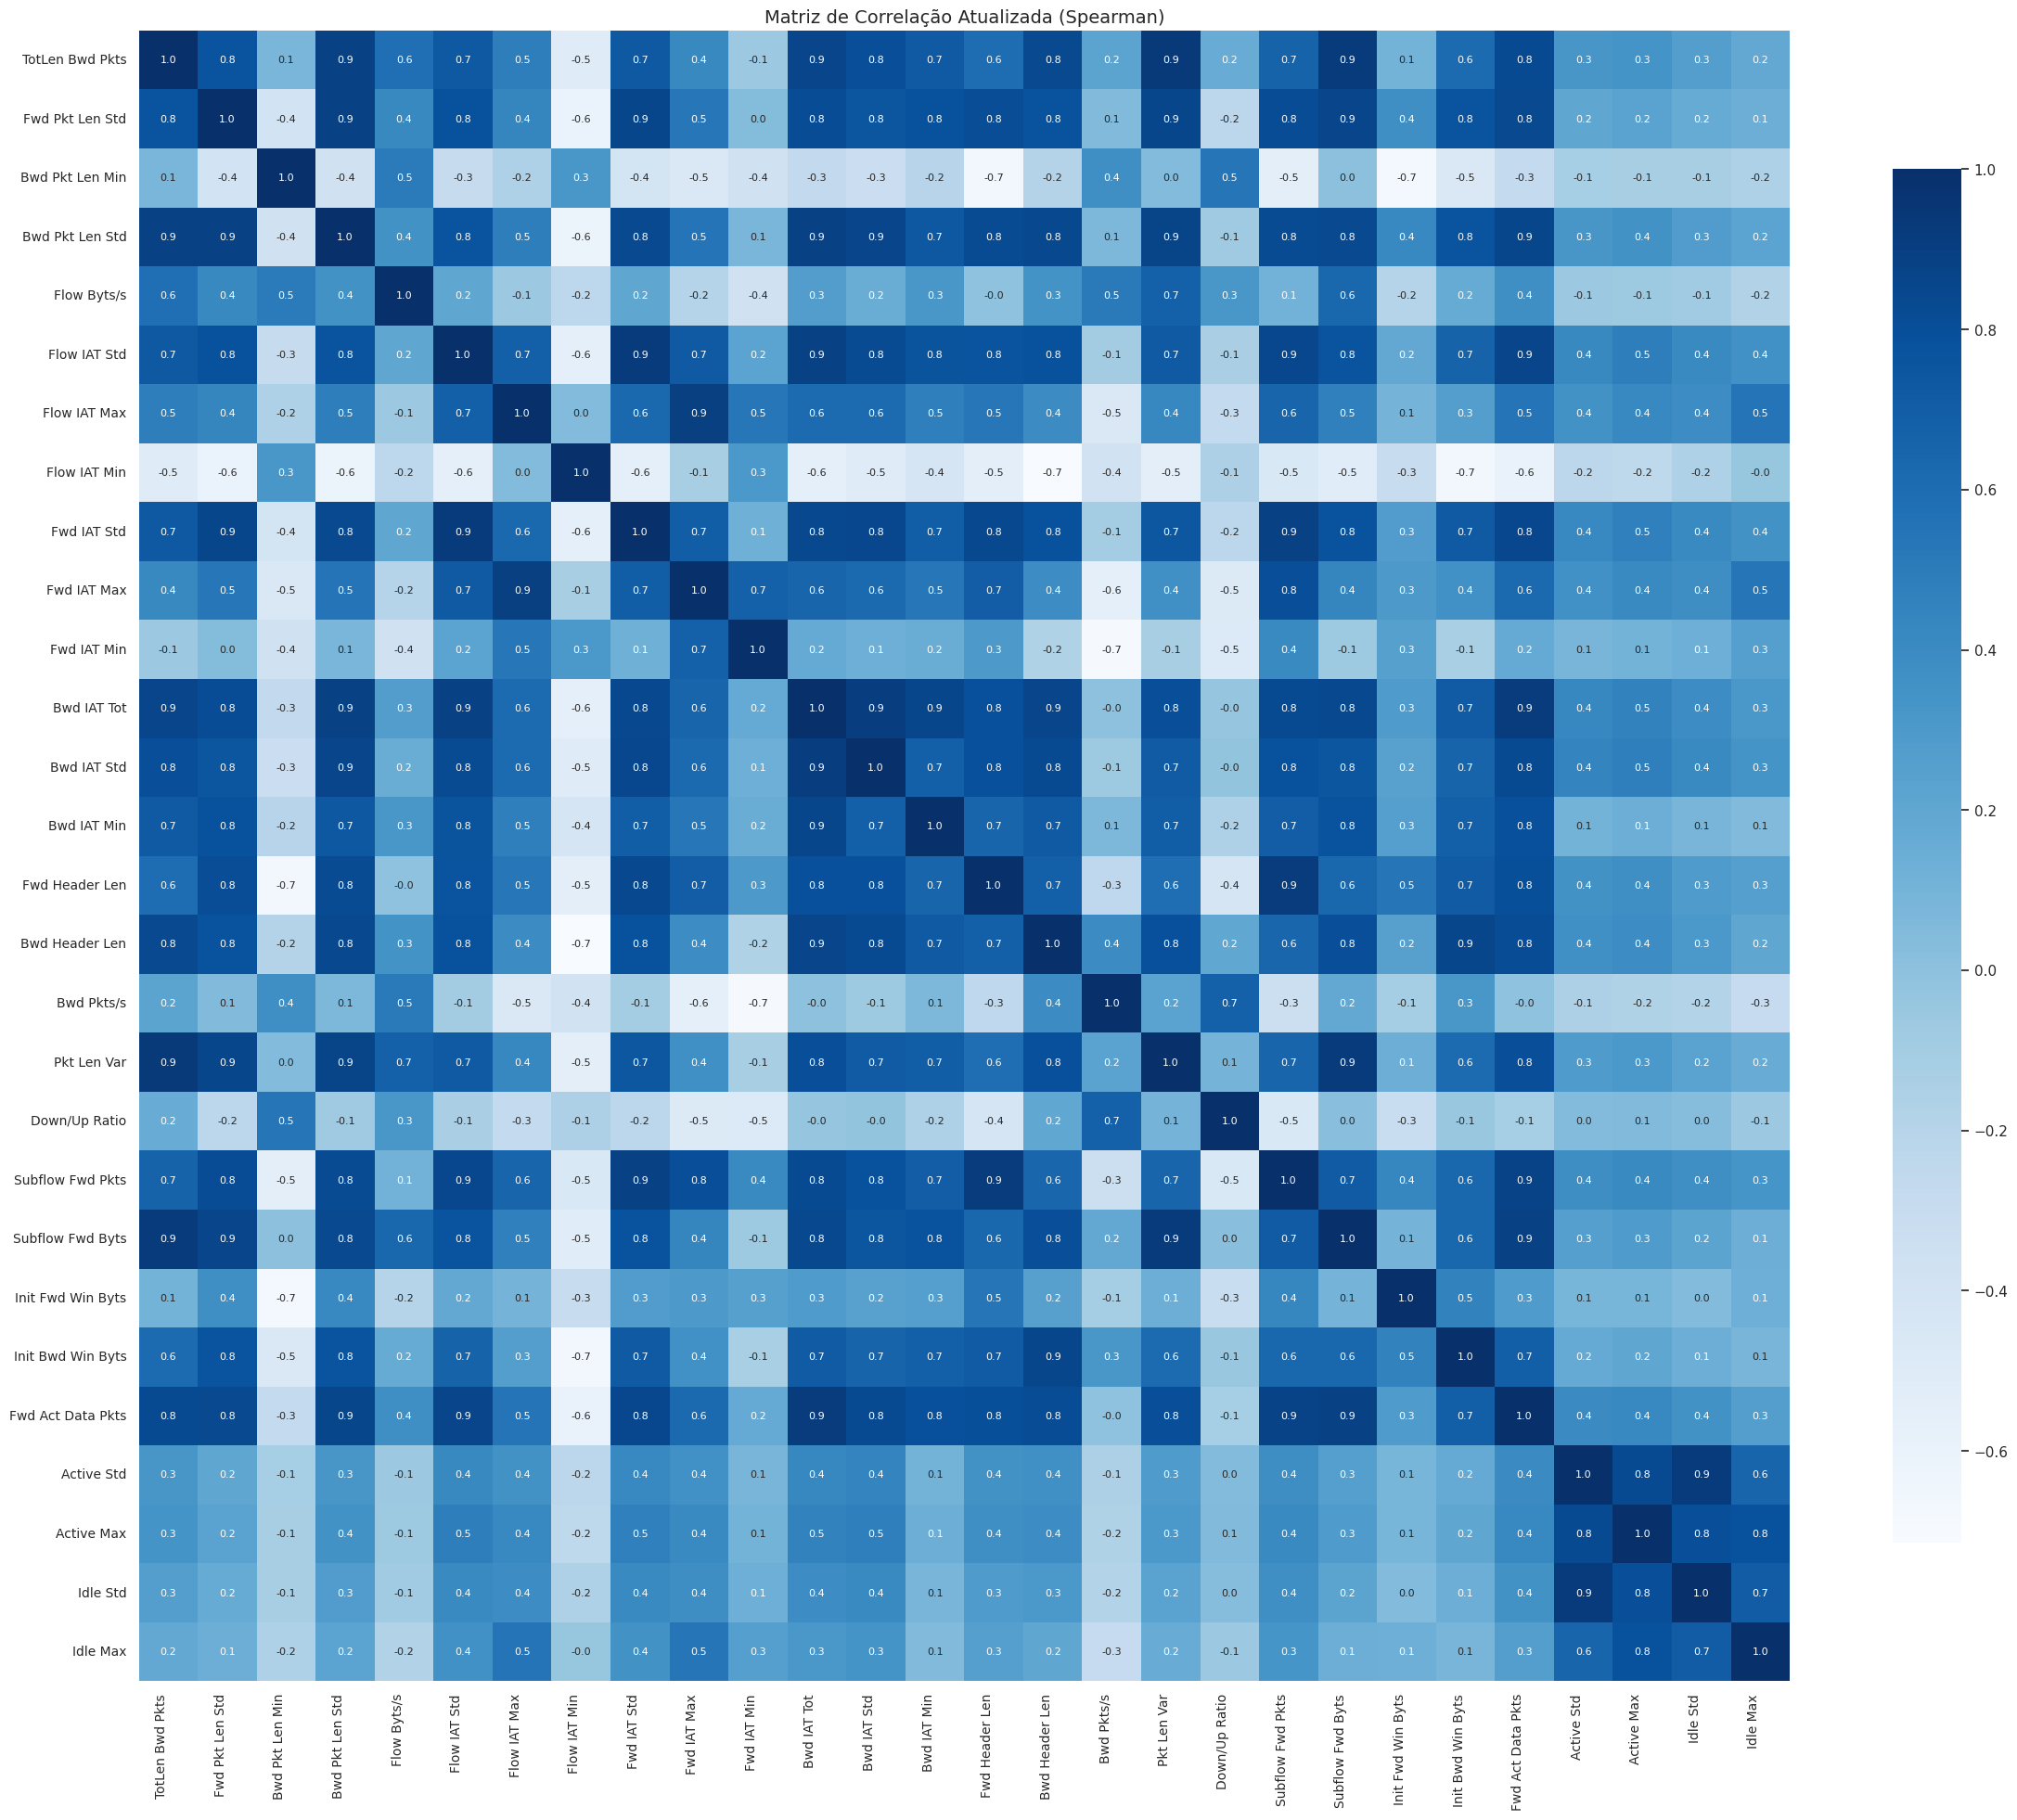

In [28]:
updated_spearman_corr_matrix = cse_pandas[numeric_columns_spearman].corr(method="spearman")

plt.figure(figsize=(24, 20))
sns.heatmap(updated_spearman_corr_matrix, annot=True, fmt=".1f", cmap='Blues', square=True, 
            annot_kws={"size": 8}, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlação Atualizada (Spearman)', fontsize=14)
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

## Criação dos Datasets Baseados nas Correlações

### Identificar Colunas a Serem Removidas (União e Interseção)

In [29]:
cols_to_remove_union = list(set(cols_to_remove_pearson).union(set(cols_to_remove_spearman)))
print(f"Colunas a serem removidas (União de Pearson e Spearman): {cols_to_remove_union}\n")

cols_to_remove_intersection = list(set(cols_to_remove_pearson).intersection(set(cols_to_remove_spearman)))
print(f"Colunas a serem removidas (Interseção de Pearson e Spearman): {cols_to_remove_intersection}\n")

Colunas a serem removidas (União de Pearson e Spearman): ['Bwd Header Len', 'Fwd Act Data Pkts', 'Subflow Bwd Byts', 'Bwd Pkt Len Mean', 'Flow IAT Std', 'Fwd IAT Max', 'Bwd IAT Max', 'Flow Pkts/s', 'Fwd IAT Mean', 'TotLen Fwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Fwd Pkts/s', 'Bwd Pkt Len Max', 'Flow IAT Min', 'Fwd Seg Size Avg', 'Active Mean', 'Tot Bwd Pkts', 'Idle Mean', 'Pkt Len Std', 'Pkt Len Mean', 'Bwd IAT Mean', 'Flow Duration', 'Subflow Bwd Pkts', 'Idle Min', 'Fwd IAT Tot', 'Bwd Pkt Len Std', 'Flow IAT Mean', 'Idle Std', 'Fwd Pkt Len Std', 'Active Min', 'Bwd Seg Size Avg', 'Pkt Len Max', 'Fwd Pkt Len Min', 'Pkt Len Min', 'Pkt Size Avg', 'Fwd IAT Std', 'Tot Fwd Pkts']

Colunas a serem removidas (Interseção de Pearson e Spearman): ['Subflow Bwd Byts', 'Pkt Len Min', 'Subflow Bwd Pkts', 'Bwd Pkt Len Mean', 'Fwd IAT Tot', 'Tot Bwd Pkts', 'Flow IAT Mean', 'Idle Mean', 'Pkt Len Std', 'TotLen Fwd Pkts', 'Tot Fwd Pkts', 'Pkt Len Mean', 'Fwd Pkt Len Mean']



### Criar Cópias do DataFrame para Cada Cenário

In [30]:
cse_pandas_no_removal = cse_pandas.copy()
cse_pandas_pearson = cse_pandas.copy()
cse_pandas_spearman = cse_pandas.copy()
cse_pandas_union = cse_pandas.copy()
cse_pandas_intersection = cse_pandas.copy()

### Remover as Colunas Altamente Correlacionadas em Cada Cenário

In [31]:
cse_pandas_pearson.drop(columns=cols_to_remove_pearson, inplace=True)

cse_pandas_spearman.drop(columns=cols_to_remove_spearman, inplace=True)

cse_pandas_union.drop(columns=cols_to_remove_union, inplace=True)

cse_pandas_intersection.drop(columns=cols_to_remove_intersection, inplace=True)

## Tratamento das Variáveis Categóricas

### Definir uma Função para Tratamento das Variáveis Categóricas

In [32]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

def tratar_variaveis_categoricas(df, low_cardinality_categorical_cols, high_cardinality_categorical_cols):
    """
    Função para tratar variáveis categóricas:
    - One-Hot Encoding para baixa cardinalidade
    - Frequency Encoding para alta cardinalidade
    """
    # One-Hot Encoding para baixa cardinalidade
    if low_cardinality_categorical_cols:
        ohe = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' para evitar multicolinearidade
        encoded_features = ohe.fit_transform(df[low_cardinality_categorical_cols])
        encoded_feature_names = ohe.get_feature_names_out(low_cardinality_categorical_cols)
        encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)
        # Resetar os índices para evitar problemas na concatenação
        encoded_df.reset_index(drop=True, inplace=True)
        df.reset_index(drop=True, inplace=True)
        # Concatenar as novas features ao DataFrame original
        df = pd.concat([df, encoded_df], axis=1)
        # Remover as colunas categóricas originais que foram codificadas
        df.drop(columns=low_cardinality_categorical_cols, inplace=True)
    
    # Frequency Encoding para alta cardinalidade
    for col in high_cardinality_categorical_cols:
        freq_encoding = df[col].value_counts() / len(df)
        df[f'{col}_FreqEnc'] = df[col].map(freq_encoding)
        df.drop(columns=[col], inplace=True)
    
    return df


### Identificar Colunas Categóricas de Baixa e Alta Cardinalidade

In [33]:
low_cardinality_threshold = 15

low_cardinality_categorical_cols = [col for col in categorical_columns if cse_pandas[col].nunique() < low_cardinality_threshold and col not in ['Label', 'Is_Attack']]
high_cardinality_categorical_cols = [col for col in categorical_columns if cse_pandas[col].nunique() >= low_cardinality_threshold and col not in ['Label', 'Is_Attack']]

print("Colunas categóricas com baixa cardinalidade para One-Hot Encoding:")
print(low_cardinality_categorical_cols)

print("\nColunas categóricas com alta cardinalidade para Frequency Encoding:")
print(high_cardinality_categorical_cols)

Colunas categóricas com baixa cardinalidade para One-Hot Encoding:
['Fwd PSH Flags', 'URG Flag Cnt', 'ECE Flag Cnt', 'CWE Flag Count', 'Fwd URG Flags', 'SYN Flag Cnt', 'ACK Flag Cnt', 'Protocol', 'PSH Flag Cnt', 'Fwd Seg Size Min', 'RST Flag Cnt', 'FIN Flag Cnt']

Colunas categóricas com alta cardinalidade para Frequency Encoding:
['Dst Port']


### Aplicar Tratamento das Variáveis Categóricas em Cada Dataset

In [34]:
cse_pandas_no_removal = tratar_variaveis_categoricas(cse_pandas_no_removal, low_cardinality_categorical_cols, high_cardinality_categorical_cols)
cse_pandas_pearson = tratar_variaveis_categoricas(cse_pandas_pearson, low_cardinality_categorical_cols, high_cardinality_categorical_cols)
cse_pandas_spearman = tratar_variaveis_categoricas(cse_pandas_spearman, low_cardinality_categorical_cols, high_cardinality_categorical_cols)
cse_pandas_union = tratar_variaveis_categoricas(cse_pandas_union, low_cardinality_categorical_cols, high_cardinality_categorical_cols)
cse_pandas_intersection = tratar_variaveis_categoricas(cse_pandas_intersection, low_cardinality_categorical_cols, high_cardinality_categorical_cols)

## Preparação dos Dados para Modelagem

### Definir as Features e o Target para Cada Dataset

In [35]:
exclude_columns = ['Label', 'Is_Attack', 'Label_Encoded', 'timestamp']

In [36]:
features_no_removal = [col for col in cse_pandas_no_removal.columns if col not in exclude_columns]
X_no_removal = cse_pandas_no_removal[features_no_removal]
y_no_removal = cse_pandas_no_removal['Is_Attack']

In [37]:
features_pearson = [col for col in cse_pandas_pearson.columns if col not in exclude_columns]
X_pearson = cse_pandas_pearson[features_pearson]
y_pearson = cse_pandas_pearson['Is_Attack']

In [38]:
features_spearman = [col for col in cse_pandas_spearman.columns if col not in exclude_columns]
X_spearman = cse_pandas_spearman[features_spearman]
y_spearman = cse_pandas_spearman['Is_Attack']

In [39]:
features_union = [col for col in cse_pandas_union.columns if col not in exclude_columns]
X_union = cse_pandas_union[features_union]
y_union = cse_pandas_union['Is_Attack']

In [40]:
features_intersection = [col for col in cse_pandas_intersection.columns if col not in exclude_columns]
X_intersection = cse_pandas_intersection[features_intersection]
y_intersection = cse_pandas_intersection['Is_Attack']

### Dividir em Conjunto de Treino e Teste

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
X_train_no_removal, X_test_no_removal, y_train_no_removal, y_test_no_removal = train_test_split(
    X_no_removal, y_no_removal, test_size=0.2, stratify=y_no_removal, random_state=42)

In [43]:
X_train_pearson, X_test_pearson, y_train_pearson, y_test_pearson = train_test_split(
    X_pearson, y_pearson, test_size=0.2, stratify=y_pearson, random_state=42)

In [44]:
X_train_spearman, X_test_spearman, y_train_spearman, y_test_spearman = train_test_split(
    X_spearman, y_spearman, test_size=0.2, stratify=y_spearman, random_state=42)

In [45]:
X_train_union, X_test_union, y_train_union, y_test_union = train_test_split(
    X_union, y_union, test_size=0.2, stratify=y_union, random_state=42)

In [46]:
X_train_intersection, X_test_intersection, y_train_intersection, y_test_intersection = train_test_split(
    X_intersection, y_intersection, test_size=0.2, stratify=y_intersection, random_state=42)

### Normalização dos Dados

In [47]:
from sklearn.preprocessing import StandardScaler

In [48]:
def normalize_data(X_train, X_test):
    scaler = StandardScaler()
    numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
    X_test[numeric_features] = scaler.transform(X_test[numeric_features])
    return X_train, X_test

In [49]:
X_train_no_removal, X_test_no_removal = normalize_data(X_train_no_removal, X_test_no_removal)
X_train_pearson, X_test_pearson = normalize_data(X_train_pearson, X_test_pearson)
X_train_spearman, X_test_spearman = normalize_data(X_train_spearman, X_test_spearman)
X_train_union, X_test_union = normalize_data(X_train_union, X_test_union)
X_train_intersection, X_test_intersection = normalize_data(X_train_intersection, X_test_intersection)

## Criação dos Datasets Baseados nas Correlações

### Quantidade de Colunas Antes e Após Remoção

In [50]:
total_columns = len(cse_pandas_no_removal.columns)
print(f"Total de colunas antes da remoção: {total_columns}\n")

num_remove_pearson = len(cols_to_remove_pearson)
num_remove_spearman = len(cols_to_remove_spearman)
num_remove_union = len(cols_to_remove_union)
num_remove_intersection = len(cols_to_remove_intersection)

num_columns_no_removal = total_columns 
num_columns_pearson = total_columns - num_remove_pearson
num_columns_spearman = total_columns - num_remove_spearman
num_columns_union = total_columns - num_remove_union
num_columns_intersection = total_columns - num_remove_intersection

Total de colunas antes da remoção: 83



In [51]:
print(cse_pandas_no_removal.columns)

Index(['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
       'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min',
       'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max',
       'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s',
       'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Len',
       'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min',
       'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var',
       'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg',
       'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts',
       'Subflow Bwd Byts', 'Init Fwd Win Byts', 'Init Bwd Win Byts',
       'Fwd Act Data Pkts', 'Active Mean', 'Active Std', 'Active Max',
       'Active 

In [52]:
data = {
    'Situação': [
        'Sem Remoção',
        'Remoção por Pearson',
        'Remoção por Spearman',
        'Remoção pela União',
        'Remoção pela Interseção'
    ],
    'Colunas Antes da Remoção': [total_columns] * 5,
    'Colunas Removidas': [0, num_remove_pearson, num_remove_spearman, num_remove_union, num_remove_intersection],
    'Colunas Restantes': [num_columns_no_removal, num_columns_pearson, num_columns_spearman, num_columns_union, num_columns_intersection]
}

df_counts = pd.DataFrame(data)
print(df_counts)

                  Situação  Colunas Antes da Remoção  Colunas Removidas  \
0              Sem Remoção                        83                  0   
1      Remoção por Pearson                        83                 22   
2     Remoção por Spearman                        83                 29   
3       Remoção pela União                        83                 38   
4  Remoção pela Interseção                        83                 13   

   Colunas Restantes  
0                 83  
1                 61  
2                 54  
3                 45  
4                 70  


In [53]:
columns_pearson = [col for col in cse_pandas_no_removal.columns if col not in cols_to_remove_pearson]
columns_spearman = [col for col in cse_pandas_no_removal.columns if col not in cols_to_remove_spearman]
columns_union = [col for col in cse_pandas_no_removal.columns if col not in cols_to_remove_union]
columns_intersection = [col for col in cse_pandas_no_removal.columns if col not in cols_to_remove_intersection]

print("Colunas restantes após remoção por Pearson:")
print(columns_pearson, "\n")

print("Colunas restantes após remoção por Spearman:")
print(columns_spearman, "\n")

print("Colunas restantes após remoção pela União:")
print(columns_union, "\n")

print("Colunas restantes após remoção pela Interseção:")
print(columns_intersection, "\n")

Colunas restantes após remoção por Pearson:
['Flow Duration', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Max', 'Fwd IAT Mean', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Max', 'Pkt Len Var', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Max', 'Idle Min', 'Label', 'timestamp', 'Is_Attack', 'Fwd PSH Flags_1', 'URG Flag Cnt_1', 'ECE Flag Cnt_1', 'CWE Flag Count_1', 'Fwd URG Flags_1', 'SYN Flag Cnt_1', 'ACK Flag Cnt_1', 'Protocol_6', 'Protocol_17', 'PSH Flag Cnt_1', 'Fwd Seg Size Min_8', 'Fwd Seg Size Min_20', 'Fwd Seg Size Min_24', 'Fwd Seg Size Min_28', 'Fwd Seg Size Min_32', 'Fwd Seg Size Min_36', 'Fwd Seg Size Min_40', 'Fwd S

## Modelagem

### Definir a Função para Treinar e Avaliar os Modelos

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

def train_and_evaluate(model, X_train, X_test, y_train, y_test, dataset_name):
    print(f"\n=== Treinando e Avaliando o Modelo no Dataset: {dataset_name} ===")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Matriz de Confusão:")
    print(confusion_matrix(y_test, y_pred))
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred, digits=4))
    return model

## verificar integridade dos conjuntos

verificando se não ta passando nenhum dado das colunas Label, label_encord, Is_Attack ou qualquer outra que não deveria estar presente

In [66]:
models = [
    "Decision Tree - Sem Remoção de Colunas Altamente Correlacionadas",
    "Random Forest - Sem Remoção de Colunas Altamente Correlacionadas",
    "Random Forest - Remoção por Correlação de Pearson",
    "Random Forest - Remoção por Correlação de Spearman",
    "Random Forest - Remoção pela União de Pearson e Spearman",
    "Random Forest - Remoção pela Interseção de Pearson e Spearman"
]

X_train_vars = [
    X_train_no_removal, 
    X_train_no_removal, 
    X_train_pearson, 
    X_train_spearman, 
    X_train_union, 
    X_train_intersection
]

X_test_vars = [
    X_test_no_removal, 
    X_test_no_removal, 
    X_test_pearson, 
    X_test_spearman, 
    X_test_union, 
    X_test_intersection
]

y_train_vars = [
    y_train_no_removal, 
    y_train_no_removal, 
    y_train_pearson, 
    y_train_spearman, 
    y_train_union, 
    y_train_intersection
]

y_test_vars = [
    y_test_no_removal, 
    y_test_no_removal, 
    y_test_pearson, 
    y_test_spearman, 
    y_test_union, 
    y_test_intersection
]

for i, model in enumerate(models):
    print(f"\n{model}")
    print("X_train (head):")
    display(X_train_vars[i].head())
    print("X_test (head):")
    display(X_test_vars[i].head())
    print("y_train (head):")
    display(y_train_vars[i].head())
    print("y_test (head):")
    display(y_test_vars[i].head())


Decision Tree - Sem Remoção de Colunas Altamente Correlacionadas
X_train (head):


,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Fwd Seg Size Min_28,Fwd Seg Size Min_32,Fwd Seg Size Min_36,Fwd Seg Size Min_40,Fwd Seg Size Min_44,Fwd Seg Size Min_48,Fwd Seg Size Min_56,RST Flag Cnt_1,FIN Flag Cnt_1,Dst Port_FreqEnc
2114480,-0.014858,-0.065342,-0.029109,-0.018221,-0.018796,-0.671491,-0.372861,-0.784090,-0.625142,-0.668199,...,-0.040548,-0.438986,-0.010408,4.433035,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-0.797553
2423496,-0.008623,-0.003602,-0.017063,0.021454,-0.017293,2.013530,-0.372861,1.877337,2.319223,0.099038,...,-0.040548,2.277976,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-1.222961
5042368,0.015915,-0.065342,-0.011040,-0.018221,-0.018796,-0.671491,-0.372861,-0.784090,-0.625142,-0.668199,...,-0.040548,2.277976,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-0.909529
682516,0.160450,-0.019037,-0.035131,0.017168,-0.018796,-0.051208,7.900779,2.183330,-0.564161,-0.668199,...,-0.040548,-0.438986,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-1.219690
2315476,-0.007597,-0.019037,-0.005017,0.021454,-0.017238,2.013530,-0.372861,2.542694,2.666758,0.127293,...,-0.040548,2.277976,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-1.223007


X_test (head):


,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Fwd Seg Size Min_28,Fwd Seg Size Min_32,Fwd Seg Size Min_36,Fwd Seg Size Min_40,Fwd Seg Size Min_44,Fwd Seg Size Min_48,Fwd Seg Size Min_56,RST Flag Cnt_1,FIN Flag Cnt_1,Dst Port_FreqEnc
4114355,-0.014856,-0.049907,-0.035131,-0.018221,-0.018796,-0.671491,-0.372861,-0.784090,-0.625142,-0.668199,...,-0.040548,-0.438986,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,1.281343
6787526,-0.014858,-0.034472,-0.029109,-0.016906,-0.018796,-0.582469,-0.372861,-0.637024,-0.499114,-0.668199,...,-0.040548,-0.438986,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-1.222894
129539,-0.014858,-0.065342,-0.029109,-0.018221,-0.018796,-0.671491,-0.372861,-0.784090,-0.625142,-0.668199,...,-0.040548,-0.438986,-0.010408,4.433035,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-0.797553
6671773,-0.014819,-0.049907,-0.029109,-0.016609,-0.018796,-0.562368,-0.372861,-0.513678,-0.435937,-0.668199,...,-0.040548,-0.438986,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-1.222811
2694493,-0.014855,-0.049907,-0.035131,-0.018221,-0.018796,-0.671491,-0.372861,-0.784090,-0.625142,-0.668199,...,-0.040548,2.277976,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,1.281343


y_train (head):


2114480    1
2423496    0
5042368    0
682516     0
2315476    0
Name: Is_Attack, dtype: category
Categories (2, int32): [0, 1]

y_test (head):


4114355    1
6787526    1
129539     1
6671773    0
2694493    1
Name: Is_Attack, dtype: category
Categories (2, int32): [0, 1]


Random Forest - Sem Remoção de Colunas Altamente Correlacionadas
X_train (head):


,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Fwd Seg Size Min_28,Fwd Seg Size Min_32,Fwd Seg Size Min_36,Fwd Seg Size Min_40,Fwd Seg Size Min_44,Fwd Seg Size Min_48,Fwd Seg Size Min_56,RST Flag Cnt_1,FIN Flag Cnt_1,Dst Port_FreqEnc
2114480,-0.014858,-0.065342,-0.029109,-0.018221,-0.018796,-0.671491,-0.372861,-0.784090,-0.625142,-0.668199,...,-0.040548,-0.438986,-0.010408,4.433035,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-0.797553
2423496,-0.008623,-0.003602,-0.017063,0.021454,-0.017293,2.013530,-0.372861,1.877337,2.319223,0.099038,...,-0.040548,2.277976,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-1.222961
5042368,0.015915,-0.065342,-0.011040,-0.018221,-0.018796,-0.671491,-0.372861,-0.784090,-0.625142,-0.668199,...,-0.040548,2.277976,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-0.909529
682516,0.160450,-0.019037,-0.035131,0.017168,-0.018796,-0.051208,7.900779,2.183330,-0.564161,-0.668199,...,-0.040548,-0.438986,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-1.219690
2315476,-0.007597,-0.019037,-0.005017,0.021454,-0.017238,2.013530,-0.372861,2.542694,2.666758,0.127293,...,-0.040548,2.277976,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-1.223007


X_test (head):


,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Fwd Seg Size Min_28,Fwd Seg Size Min_32,Fwd Seg Size Min_36,Fwd Seg Size Min_40,Fwd Seg Size Min_44,Fwd Seg Size Min_48,Fwd Seg Size Min_56,RST Flag Cnt_1,FIN Flag Cnt_1,Dst Port_FreqEnc
4114355,-0.014856,-0.049907,-0.035131,-0.018221,-0.018796,-0.671491,-0.372861,-0.784090,-0.625142,-0.668199,...,-0.040548,-0.438986,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,1.281343
6787526,-0.014858,-0.034472,-0.029109,-0.016906,-0.018796,-0.582469,-0.372861,-0.637024,-0.499114,-0.668199,...,-0.040548,-0.438986,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-1.222894
129539,-0.014858,-0.065342,-0.029109,-0.018221,-0.018796,-0.671491,-0.372861,-0.784090,-0.625142,-0.668199,...,-0.040548,-0.438986,-0.010408,4.433035,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-0.797553
6671773,-0.014819,-0.049907,-0.029109,-0.016609,-0.018796,-0.562368,-0.372861,-0.513678,-0.435937,-0.668199,...,-0.040548,-0.438986,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-1.222811
2694493,-0.014855,-0.049907,-0.035131,-0.018221,-0.018796,-0.671491,-0.372861,-0.784090,-0.625142,-0.668199,...,-0.040548,2.277976,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,1.281343


y_train (head):


2114480    1
2423496    0
5042368    0
682516     0
2315476    0
Name: Is_Attack, dtype: category
Categories (2, int32): [0, 1]

y_test (head):


4114355    1
6787526    1
129539     1
6671773    0
2694493    1
Name: Is_Attack, dtype: category
Categories (2, int32): [0, 1]


Random Forest - Remoção por Correlação de Pearson
X_train (head):


,Flow Duration,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Bwd Pkt Len Max,Bwd Pkt Len Min,Flow Byts/s,Flow Pkts/s,Flow IAT Max,Fwd IAT Mean,...,Fwd Seg Size Min_28,Fwd Seg Size Min_32,Fwd Seg Size Min_36,Fwd Seg Size Min_40,Fwd Seg Size Min_44,Fwd Seg Size Min_48,Fwd Seg Size Min_56,RST Flag Cnt_1,FIN Flag Cnt_1,Dst Port_FreqEnc
2114480,-0.014858,-0.018796,-0.671491,-0.372861,-0.668199,-0.445036,-0.067822,2.960064,-0.007510,-0.010831,...,-0.040548,-0.438986,-0.010408,4.433035,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-0.797553
2423496,-0.008623,-0.017293,2.013530,-0.372861,0.099038,-0.445036,-0.067737,-0.249123,-0.002843,-0.007751,...,-0.040548,2.277976,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-1.222961
5042368,0.015915,-0.018796,-0.671491,-0.372861,-0.668199,-0.445036,-0.067822,-0.249129,0.005904,-0.010831,...,-0.040548,2.277976,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-0.909529
682516,0.160450,-0.018796,-0.051208,7.900779,-0.668199,-0.445036,-0.067820,-0.249129,0.059489,0.104621,...,-0.040548,-0.438986,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-1.219690
2315476,-0.007597,-0.017238,2.013530,-0.372861,0.127293,-0.445036,-0.067748,-0.249124,-0.002046,-0.006069,...,-0.040548,2.277976,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-1.223007


X_test (head):


,Flow Duration,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Bwd Pkt Len Max,Bwd Pkt Len Min,Flow Byts/s,Flow Pkts/s,Flow IAT Max,Fwd IAT Mean,...,Fwd Seg Size Min_28,Fwd Seg Size Min_32,Fwd Seg Size Min_36,Fwd Seg Size Min_40,Fwd Seg Size Min_44,Fwd Seg Size Min_48,Fwd Seg Size Min_56,RST Flag Cnt_1,FIN Flag Cnt_1,Dst Port_FreqEnc
4114355,-0.014856,-0.018796,-0.671491,-0.372861,-0.668199,-0.445036,-0.067822,-0.245311,-0.007508,-0.010826,...,-0.040548,-0.438986,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,1.281343
6787526,-0.014858,-0.018796,-0.582469,-0.372861,-0.668199,-0.445036,0.028758,-0.108066,-0.007510,-0.010831,...,-0.040548,-0.438986,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-1.222894
129539,-0.014858,-0.018796,-0.671491,-0.372861,-0.668199,-0.445036,-0.067822,2.960064,-0.007510,-0.010831,...,-0.040548,-0.438986,-0.010408,4.433035,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-0.797553
6671773,-0.014819,-0.018796,-0.562368,-0.372861,-0.668199,-0.445036,-0.067425,-0.248774,-0.007480,-0.010753,...,-0.040548,-0.438986,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-1.222811
2694493,-0.014855,-0.018796,-0.671491,-0.372861,-0.668199,-0.445036,-0.067822,-0.246289,-0.007507,-0.010825,...,-0.040548,2.277976,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,1.281343


y_train (head):


2114480    1
2423496    0
5042368    0
682516     0
2315476    0
Name: Is_Attack, dtype: category
Categories (2, int32): [0, 1]

y_test (head):


4114355    1
6787526    1
129539     1
6671773    0
2694493    1
Name: Is_Attack, dtype: category
Categories (2, int32): [0, 1]


Random Forest - Remoção por Correlação de Spearman
X_train (head):


,TotLen Bwd Pkts,Fwd Pkt Len Std,Bwd Pkt Len Min,Bwd Pkt Len Std,Flow Byts/s,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Std,Fwd IAT Max,...,Fwd Seg Size Min_28,Fwd Seg Size Min_32,Fwd Seg Size Min_36,Fwd Seg Size Min_40,Fwd Seg Size Min_44,Fwd Seg Size Min_48,Fwd Seg Size Min_56,RST Flag Cnt_1,FIN Flag Cnt_1,Dst Port_FreqEnc
2114480,-0.018796,-0.625142,-0.445036,-0.640623,-0.067822,-0.003114,-0.007510,-0.002151,-0.003314,-0.007296,...,-0.040548,-0.438986,-0.010408,4.433035,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-0.797553
2423496,-0.017293,2.319223,-0.445036,0.435247,-0.067737,0.000531,-0.002843,-0.002151,0.001493,-0.002629,...,-0.040548,2.277976,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-1.222961
5042368,-0.018796,-0.625142,-0.445036,-0.640623,-0.067822,0.008760,0.005904,-0.002151,-0.003314,-0.007296,...,-0.040548,2.277976,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-0.909529
682516,-0.018796,-0.564161,-0.445036,-0.640623,-0.067820,0.041053,0.059489,0.020414,0.040853,0.059703,...,-0.040548,-0.438986,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-1.219690
2315476,-0.017238,2.666758,-0.445036,0.223433,-0.067748,0.000882,-0.002046,-0.002151,0.003193,-0.001833,...,-0.040548,2.277976,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-1.223007


X_test (head):


,TotLen Bwd Pkts,Fwd Pkt Len Std,Bwd Pkt Len Min,Bwd Pkt Len Std,Flow Byts/s,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Std,Fwd IAT Max,...,Fwd Seg Size Min_28,Fwd Seg Size Min_32,Fwd Seg Size Min_36,Fwd Seg Size Min_40,Fwd Seg Size Min_44,Fwd Seg Size Min_48,Fwd Seg Size Min_56,RST Flag Cnt_1,FIN Flag Cnt_1,Dst Port_FreqEnc
4114355,-0.018796,-0.625142,-0.445036,-0.640623,-0.067822,-0.003114,-0.007508,-0.002149,-0.003314,-0.007294,...,-0.040548,-0.438986,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,1.281343
6787526,-0.018796,-0.499114,-0.445036,-0.640623,0.028758,-0.003114,-0.007510,-0.002151,-0.003314,-0.007296,...,-0.040548,-0.438986,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-1.222894
129539,-0.018796,-0.625142,-0.445036,-0.640623,-0.067822,-0.003114,-0.007510,-0.002151,-0.003314,-0.007296,...,-0.040548,-0.438986,-0.010408,4.433035,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-0.797553
6671773,-0.018796,-0.435937,-0.445036,-0.640623,-0.067425,-0.003070,-0.007480,-0.002151,-0.003314,-0.007266,...,-0.040548,-0.438986,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-1.222811
2694493,-0.018796,-0.625142,-0.445036,-0.640623,-0.067822,-0.003114,-0.007507,-0.002148,-0.003314,-0.007294,...,-0.040548,2.277976,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,1.281343


y_train (head):


2114480    1
2423496    0
5042368    0
682516     0
2315476    0
Name: Is_Attack, dtype: category
Categories (2, int32): [0, 1]

y_test (head):


4114355    1
6787526    1
129539     1
6671773    0
2694493    1
Name: Is_Attack, dtype: category
Categories (2, int32): [0, 1]


Random Forest - Remoção pela União de Pearson e Spearman
X_train (head):


,TotLen Bwd Pkts,Bwd Pkt Len Min,Flow Byts/s,Flow IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Std,Bwd IAT Min,Fwd Header Len,Bwd Pkts/s,...,Fwd Seg Size Min_28,Fwd Seg Size Min_32,Fwd Seg Size Min_36,Fwd Seg Size Min_40,Fwd Seg Size Min_44,Fwd Seg Size Min_48,Fwd Seg Size Min_56,RST Flag Cnt_1,FIN Flag Cnt_1,Dst Port_FreqEnc
2114480,-0.018796,-0.445036,-0.067822,-0.007510,-0.002254,-0.262808,-0.224892,-0.060453,-0.055767,3.568790,...,-0.040548,-0.438986,-0.010408,4.433035,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-0.797553
2423496,-0.017293,-0.445036,-0.067737,-0.002843,-0.002254,-0.260859,-0.218984,-0.057277,0.037150,-0.229509,...,-0.040548,2.277976,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-1.222961
5042368,-0.018796,-0.445036,-0.067822,0.005904,-0.002254,0.636289,1.229514,0.930529,-0.061574,-0.229513,...,-0.040548,2.277976,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-0.909529
682516,-0.018796,-0.445036,-0.067820,0.059489,0.020311,-0.262808,-0.224892,-0.060453,-0.061574,-0.229514,...,-0.040548,-0.438986,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-1.219690
2315476,-0.017238,-0.445036,-0.067748,-0.002046,-0.002231,-0.259839,-0.221741,-0.058696,0.013921,-0.229507,...,-0.040548,2.277976,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-1.223007


X_test (head):


,TotLen Bwd Pkts,Bwd Pkt Len Min,Flow Byts/s,Flow IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Std,Bwd IAT Min,Fwd Header Len,Bwd Pkts/s,...,Fwd Seg Size Min_28,Fwd Seg Size Min_32,Fwd Seg Size Min_36,Fwd Seg Size Min_40,Fwd Seg Size Min_44,Fwd Seg Size Min_48,Fwd Seg Size Min_56,RST Flag Cnt_1,FIN Flag Cnt_1,Dst Port_FreqEnc
4114355,-0.018796,-0.445036,-0.067822,-0.007508,-0.002252,-0.262808,-0.224892,-0.060453,-0.055767,-0.229514,...,-0.040548,-0.438986,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,1.281343
6787526,-0.018796,-0.445036,0.028758,-0.007510,-0.002254,-0.262808,-0.224892,-0.060453,-0.041248,-0.146035,...,-0.040548,-0.438986,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-1.222894
129539,-0.018796,-0.445036,-0.067822,-0.007510,-0.002254,-0.262808,-0.224892,-0.060453,-0.055767,3.568790,...,-0.040548,-0.438986,-0.010408,4.433035,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-0.797553
6671773,-0.018796,-0.445036,-0.067425,-0.007480,-0.002226,-0.262808,-0.224892,-0.060453,-0.055767,-0.229234,...,-0.040548,-0.438986,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-1.222811
2694493,-0.018796,-0.445036,-0.067822,-0.007507,-0.002252,-0.262808,-0.224892,-0.060453,-0.038345,-0.229514,...,-0.040548,2.277976,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,1.281343


y_train (head):


2114480    1
2423496    0
5042368    0
682516     0
2315476    0
Name: Is_Attack, dtype: category
Categories (2, int32): [0, 1]

y_test (head):


4114355    1
6787526    1
129539     1
6671773    0
2694493    1
Name: Is_Attack, dtype: category
Categories (2, int32): [0, 1]


Random Forest - Remoção pela Interseção de Pearson e Spearman
X_train (head):


,Flow Duration,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,...,Fwd Seg Size Min_28,Fwd Seg Size Min_32,Fwd Seg Size Min_36,Fwd Seg Size Min_40,Fwd Seg Size Min_44,Fwd Seg Size Min_48,Fwd Seg Size Min_56,RST Flag Cnt_1,FIN Flag Cnt_1,Dst Port_FreqEnc
2114480,-0.014858,-0.018796,-0.671491,-0.372861,-0.625142,-0.668199,-0.445036,-0.640623,-0.067822,2.960064,...,-0.040548,-0.438986,-0.010408,4.433035,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-0.797553
2423496,-0.008623,-0.017293,2.013530,-0.372861,2.319223,0.099038,-0.445036,0.435247,-0.067737,-0.249123,...,-0.040548,2.277976,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-1.222961
5042368,0.015915,-0.018796,-0.671491,-0.372861,-0.625142,-0.668199,-0.445036,-0.640623,-0.067822,-0.249129,...,-0.040548,2.277976,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-0.909529
682516,0.160450,-0.018796,-0.051208,7.900779,-0.564161,-0.668199,-0.445036,-0.640623,-0.067820,-0.249129,...,-0.040548,-0.438986,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-1.219690
2315476,-0.007597,-0.017238,2.013530,-0.372861,2.666758,0.127293,-0.445036,0.223433,-0.067748,-0.249124,...,-0.040548,2.277976,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-1.223007


X_test (head):


,Flow Duration,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,...,Fwd Seg Size Min_28,Fwd Seg Size Min_32,Fwd Seg Size Min_36,Fwd Seg Size Min_40,Fwd Seg Size Min_44,Fwd Seg Size Min_48,Fwd Seg Size Min_56,RST Flag Cnt_1,FIN Flag Cnt_1,Dst Port_FreqEnc
4114355,-0.014856,-0.018796,-0.671491,-0.372861,-0.625142,-0.668199,-0.445036,-0.640623,-0.067822,-0.245311,...,-0.040548,-0.438986,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,1.281343
6787526,-0.014858,-0.018796,-0.582469,-0.372861,-0.499114,-0.668199,-0.445036,-0.640623,0.028758,-0.108066,...,-0.040548,-0.438986,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-1.222894
129539,-0.014858,-0.018796,-0.671491,-0.372861,-0.625142,-0.668199,-0.445036,-0.640623,-0.067822,2.960064,...,-0.040548,-0.438986,-0.010408,4.433035,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-0.797553
6671773,-0.014819,-0.018796,-0.562368,-0.372861,-0.435937,-0.668199,-0.445036,-0.640623,-0.067425,-0.248774,...,-0.040548,-0.438986,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,-1.222811
2694493,-0.014855,-0.018796,-0.671491,-0.372861,-0.625142,-0.668199,-0.445036,-0.640623,-0.067822,-0.246289,...,-0.040548,2.277976,-0.010408,-0.225579,-0.003753,-0.000834,-0.000417,-0.420246,-0.059604,1.281343


y_train (head):


2114480    1
2423496    0
5042368    0
682516     0
2315476    0
Name: Is_Attack, dtype: category
Categories (2, int32): [0, 1]

y_test (head):


4114355    1
6787526    1
129539     1
6671773    0
2694493    1
Name: Is_Attack, dtype: category
Categories (2, int32): [0, 1]

### Treinar e Avaliar com Árvores de Decisão (Decision Trees)

In [55]:
dt_model = DecisionTreeClassifier(random_state=42)

In [56]:
model_dt_no_removal = train_and_evaluate(dt_model, X_train_no_removal, X_test_no_removal, y_train_no_removal, y_test_no_removal, "Decision Tree - Sem Remoção de Colunas Altamente Correlacionadas")

model_dt_pearson = train_and_evaluate(dt_model, X_train_pearson, X_test_pearson, y_train_pearson, y_test_pearson, "Decision Tree - Remoção por Correlação de Pearson")

model_dt_spearman = train_and_evaluate(dt_model, X_train_spearman, X_test_spearman, y_train_spearman, y_test_spearman, "Decision Tree - Remoção por Correlação de Spearman")

model_dt_union = train_and_evaluate(dt_model, X_train_union, X_test_union, y_train_union, y_test_union, "Decision Tree - Remoção pela União de Pearson e Spearman")

model_dt_intersection = train_and_evaluate(dt_model, X_train_intersection, X_test_intersection, y_train_intersection, y_test_intersection, "Decision Tree - Remoção pela Interseção de Pearson e Spearman")


=== Treinando e Avaliando o Modelo no Dataset: Decision Tree - Sem Remoção de Colunas Altamente Correlacionadas ===
Matriz de Confusão:
[[1046476   16846]
 [  27964  346612]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0     0.9740    0.9842    0.9790   1063322
           1     0.9537    0.9253    0.9393    374576

    accuracy                         0.9688   1437898
   macro avg     0.9638    0.9548    0.9592   1437898
weighted avg     0.9687    0.9688    0.9687   1437898


=== Treinando e Avaliando o Modelo no Dataset: Decision Tree - Remoção por Correlação de Pearson ===
Matriz de Confusão:
[[1046491   16831]
 [  28085  346491]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0     0.9739    0.9842    0.9790   1063322
           1     0.9537    0.9250    0.9391    374576

    accuracy                         0.9688   1437898
   macro avg     0.9638    0.9546    0.9591   1437898
weight

### Random Forest

In [57]:
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=None)

In [58]:
model_rf_no_removal = train_and_evaluate(rf_model, X_train_no_removal, X_test_no_removal, y_train_no_removal, y_test_no_removal, "Random Forest - Sem Remoção de Colunas Altamente Correlacionadas")

model_rf_pearson = train_and_evaluate(rf_model, X_train_pearson, X_test_pearson, y_train_pearson, y_test_pearson, "Random Forest - Remoção por Correlação de Pearson")

model_rf_spearman = train_and_evaluate(rf_model, X_train_spearman, X_test_spearman, y_train_spearman, y_test_spearman, "Random Forest - Remoção por Correlação de Spearman")

model_rf_union = train_and_evaluate(rf_model, X_train_union, X_test_union, y_train_union, y_test_union, "Random Forest - Remoção pela União de Pearson e Spearman")

model_rf_intersection = train_and_evaluate(rf_model, X_train_intersection, X_test_intersection, y_train_intersection, y_test_intersection, "Random Forest - Remoção pela Interseção de Pearson e Spearman")


=== Treinando e Avaliando o Modelo no Dataset: Random Forest - Sem Remoção de Colunas Altamente Correlacionadas ===
Matriz de Confusão:
[[1057892    5430]
 [  30346  344230]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0     0.9721    0.9949    0.9834   1063322
           1     0.9845    0.9190    0.9506    374576

    accuracy                         0.9751   1437898
   macro avg     0.9783    0.9569    0.9670   1437898
weighted avg     0.9753    0.9751    0.9748   1437898


=== Treinando e Avaliando o Modelo no Dataset: Random Forest - Remoção por Correlação de Pearson ===
Matriz de Confusão:
[[1057568    5754]
 [  30120  344456]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0     0.9723    0.9946    0.9833   1063322
           1     0.9836    0.9196    0.9505    374576

    accuracy                         0.9751   1437898
   macro avg     0.9779    0.9571    0.9669   1437898
weight

In [59]:
import joblib

def salvar_modelo(model, nome_arquivo):
    joblib.dump(model, f"{nome_arquivo}.pkl")
    print(f"Modelo salvo como {nome_arquivo}.pkl")

In [60]:
salvar_modelo(model_dt_no_removal, "model_dt_no_removal")
salvar_modelo(model_dt_pearson, "model_dt_pearson")
salvar_modelo(model_dt_spearman, "model_dt_spearman")
salvar_modelo(model_dt_union, "model_dt_union")
salvar_modelo(model_dt_intersection, "model_dt_intersection")

salvar_modelo(model_rf_no_removal, "model_rf_no_removal")
salvar_modelo(model_rf_pearson, "model_rf_pearson")
salvar_modelo(model_rf_spearman, "model_rf_spearman")
salvar_modelo(model_rf_union, "model_rf_union")
salvar_modelo(model_rf_intersection, "model_rf_intersection")

Modelo salvo como model_dt_no_removal.pkl
Modelo salvo como model_dt_pearson.pkl
Modelo salvo como model_dt_spearman.pkl
Modelo salvo como model_dt_union.pkl
Modelo salvo como model_dt_intersection.pkl
Modelo salvo como model_rf_no_removal.pkl
Modelo salvo como model_rf_pearson.pkl
Modelo salvo como model_rf_spearman.pkl
Modelo salvo como model_rf_union.pkl
Modelo salvo como model_rf_intersection.pkl
